In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle
from graph_creator.utilities import make_node_edge_df
from subgraphs.SubgraphIsomorphismChecker import IsomorphicGrapCoverageCounter
from graph_creator.ActorGraph import ActorType
from glob import glob

os.chdir('../..')
print(os.getcwd())

# Import subgraph types from the new module
from subgraphs.subgraph_types import get_all_subgraphs, get_simple_patterns, get_complex_patterns
from subgraphs.SubgraphExtractor import SubgraphExtractor



/Users/marius/code/graph_coverage


In [3]:
# graph_paths_carla = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*pkl")
# len(graph_paths_carla)

# graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*pkl")
# graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*pkl")

# len(graph_paths_argo)

In [5]:
graph_setting = '1_50_50_10_20_20_4_4_4'
carla_graph_dir = f'carla_actor_graph_setting_{graph_setting}'
argoverse_graph_dir = f'argoverse_actor_graph_setting_{graph_setting}'


carla_components_dir = f"actor_graphs/{carla_graph_dir}/{carla_graph_dir}_components_nx"
argo_components_dir = f"actor_graphs/{argoverse_graph_dir}/{argoverse_graph_dir}_components_nx"

graph_paths_carla_components = glob(f"{carla_components_dir}/*.pkl")
print(f"Number of Carla component graphs: {len(graph_paths_carla_components)}")

graph_paths_argo_components = glob(f"{argo_components_dir}/*.pkl")
print(f"Number of Argoverse component graphs: {len(graph_paths_argo_components)}")

Number of Carla component graphs: 202001
Number of Argoverse component graphs: 301419


## Load all subgraph patterns from subgraph_types module

In [6]:
# Get all subgraph patterns from the subgraph_types module
coverage_graphs = get_all_subgraphs()

print(f"Total number of subgraph patterns: {len(coverage_graphs)}")
print(f"\nSubgraph patterns:")
for name in coverage_graphs.keys():
    print(f"  - {name}")


Total number of subgraph patterns: 18

Subgraph patterns:
  - simple_following
  - simple_opposite
  - simple_neighbor
  - lead_vehicle_in_front_with_neighbor_vehicle_intersection
  - cut_in
  - cut_in_intersection
  - platoon_with_intersection
  - opposite_traffic_at_intersection
  - lead_with_neighbor_at_intersection
  - triple_opposite_traffic_intersection
  - lead_vehicle_in_front_with_neighbor_vehicle
  - lead_vehicle_in_front_following_vehicle_in_the_back
  - cut_out
  - cut_out_intersection
  - four_vehicle_intersection_platoon
  - four_vehicle_opposite_intersection
  - lead_neighbor_opposite_vehicle
  - lead_neighbor_opposite_vehicle_intersection


In [9]:

isom_cov_counter_carla = IsomorphicGrapCoverageCounter(
    coverage_graphs, 
    graph_paths_carla_components[:], 
    node_match=["actor_type", "lane_change", "is_on_intersection"], 
    edge_match=["edge_type"]
)
isom_cov_counter_carla.count_isomorphic_graphs()
cov_data_df_carla = isom_cov_counter_carla.cov_data_df

print(f"Carla coverage analysis complete!")
print(f"Shape: {cov_data_df_carla.shape}")
cov_data_df_carla.head(10)

Checking isomorphic graphs: 100%|██████████| 202001/202001 [06:12<00:00, 542.41it/s]


Carla coverage analysis complete!
Shape: (202001, 22)


,simple_following,simple_opposite,simple_neighbor,lead_vehicle_in_front_with_neighbor_vehicle_intersection,cut_in,cut_in_intersection,platoon_with_intersection,opposite_traffic_at_intersection,lead_with_neighbor_at_intersection,triple_opposite_traffic_intersection,...,cut_out,cut_out_intersection,four_vehicle_intersection_platoon,four_vehicle_opposite_intersection,lead_neighbor_opposite_vehicle,lead_neighbor_opposite_vehicle_intersection,degree,density,diameter,path
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/carla_actor_graph_setting_1_50_50...
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.666667,0.666667,2,actor_graphs/carla_actor_graph_setting_1_50_50...
2,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,3.000000,0.500000,3,actor_graphs/carla_actor_graph_setting_1_50_50...
3,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.666667,0.666667,2,actor_graphs/carla_actor_graph_setting_1_50_50...
4,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/carla_actor_graph_setting_1_50_50...
5,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,3.333333,0.333333,4,actor_graphs/carla_actor_graph_setting_1_50_50...
6,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/carla_actor_graph_setting_1_50_50...
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/carla_actor_graph_setting_1_50_50...
8,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,3.000000,0.500000,3,actor_graphs/carla_actor_graph_setting_1_50_50...
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/carla_actor_graph_setting_1_50_50...


In [10]:
isom_cov_counter_argo = IsomorphicGrapCoverageCounter(
    coverage_graphs, 
    graph_paths_argo_components[:], 
    node_match=["actor_type", "lane_change", "is_on_intersection"], 
    edge_match=["edge_type"]
)
isom_cov_counter_argo.count_isomorphic_graphs()
cov_data_df_argo = isom_cov_counter_argo.cov_data_df

print(f"Argoverse coverage analysis complete!")
print(f"Shape: {cov_data_df_argo.shape}")
cov_data_df_argo.head(5)

Checking isomorphic graphs:   0%|          | 0/301419 [00:00<?, ?it/s]

Checking isomorphic graphs: 100%|██████████| 301419/301419 [12:06<00:00, 414.70it/s]


Argoverse coverage analysis complete!
Shape: (301419, 22)


,simple_following,simple_opposite,simple_neighbor,lead_vehicle_in_front_with_neighbor_vehicle_intersection,cut_in,cut_in_intersection,platoon_with_intersection,opposite_traffic_at_intersection,lead_with_neighbor_at_intersection,triple_opposite_traffic_intersection,...,cut_out,cut_out_intersection,four_vehicle_intersection_platoon,four_vehicle_opposite_intersection,lead_neighbor_opposite_vehicle,lead_neighbor_opposite_vehicle_intersection,degree,density,diameter,path
0,True,True,True,False,False,False,True,True,True,True,...,False,False,True,True,False,False,3.333333,0.333333,4,actor_graphs/argoverse_actor_graph_setting_1_5...
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.000000,1.000000,1,actor_graphs/argoverse_actor_graph_setting_1_5...
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.666667,0.666667,2,actor_graphs/argoverse_actor_graph_setting_1_5...
3,True,True,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,2.666667,0.666667,2,actor_graphs/argoverse_actor_graph_setting_1_5...
4,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.666667,0.666667,2,actor_graphs/argoverse_actor_graph_setting_1_5...


## Coverage Metrics Analysis

### Definition 1: Absolute Coverage (number of graphs containing each subgraph)
### Definition 2: Relative Coverage (percentage of graphs containing each subgraph)


In [11]:
# Calculate coverage metrics for both datasets
def calculate_coverage_metrics(cov_df, dataset_name):
    """Calculate both absolute and relative coverage metrics."""
    subgraph_cols = [col for col in cov_df.columns if col not in ['degree', 'density', 'diameter', 'path']]
    
    # Absolute coverage: count of graphs containing each subgraph
    absolute_coverage = cov_df[subgraph_cols].sum()
    
    # Relative coverage: percentage of graphs containing each subgraph
    relative_coverage = (cov_df[subgraph_cols].sum() / len(cov_df)) * 100
    
    # Combine into a dataframe
    coverage_df = pd.DataFrame({
        'subgraph': subgraph_cols,
        'absolute_count': absolute_coverage.values,
        'relative_percentage': relative_coverage.values
    })
    coverage_df = coverage_df.sort_values('absolute_count', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"Coverage Metrics for {dataset_name}")
    print(f"{'='*60}")
    print(f"Total graphs analyzed: {len(cov_df)}")
    print(f"\nTop 10 most covered subgraphs:")
    print(coverage_df.head(10).to_string(index=False))
    print(f"\nBottom 10 least covered subgraphs:")
    print(coverage_df.tail(10).to_string(index=False))
    
    return coverage_df

# Calculate metrics for both datasets
coverage_carla = calculate_coverage_metrics(cov_data_df_carla, "CARLA")
coverage_argo = calculate_coverage_metrics(cov_data_df_argo, "ARGOVERSE")



Coverage Metrics for CARLA
Total graphs analyzed: 202001

Top 10 most covered subgraphs:
                                           subgraph  absolute_count  relative_percentage
                                   simple_following          168371            83.351568
                                    simple_neighbor          168371            83.351568
                                    simple_opposite          168371            83.351568
lead_vehicle_in_front_following_vehicle_in_the_back           84172            41.669101
        lead_vehicle_in_front_with_neighbor_vehicle           84172            41.669101
                   opposite_traffic_at_intersection           24809            12.281622
                 lead_with_neighbor_at_intersection           24809            12.281622
               triple_opposite_traffic_intersection           12166             6.022742
                          platoon_with_intersection           12166             6.022742
                  fo

## Comparative Analysis: Identify Differences Between Datasets


In [12]:
# Compare coverage between datasets
comparison_df = pd.merge(
    coverage_carla[['subgraph', 'absolute_count', 'relative_percentage']],
    coverage_argo[['subgraph', 'absolute_count', 'relative_percentage']],
    on='subgraph',
    suffixes=('_carla', '_argo')
)

# Calculate differences
comparison_df['abs_diff'] = comparison_df['absolute_count_carla'] - comparison_df['absolute_count_argo']
comparison_df['rel_diff'] = comparison_df['relative_percentage_carla'] - comparison_df['relative_percentage_argo']

# Identify holes: subgraphs missing or very rare in one dataset
threshold_rare = 1.0  # Less than 1% coverage
comparison_df['hole_in_carla'] = comparison_df['relative_percentage_carla'] < threshold_rare
comparison_df['hole_in_argo'] = comparison_df['relative_percentage_argo'] < threshold_rare

print("\n" + "="*80)
print("COVERAGE COMPARISON: CARLA vs ARGOVERSE")
print("="*80)

print("\n1. Subgraphs with LARGEST DIFFERENCES (sorted by relative difference):")
print(comparison_df.sort_values('rel_diff', key=abs, ascending=False).head(10).to_string(index=False))

print("\n2. HOLES IN CARLA (subgraphs rare or missing in Carla but present in Argoverse):")
holes_carla = comparison_df[comparison_df['hole_in_carla'] & ~comparison_df['hole_in_argo']]
if len(holes_carla) > 0:
    print(holes_carla[['subgraph', 'relative_percentage_carla', 'relative_percentage_argo']].to_string(index=False))
else:
    print("No significant holes found in Carla dataset")

print("\n3. HOLES IN ARGOVERSE (subgraphs rare or missing in Argoverse but present in Carla):")
holes_argo = comparison_df[comparison_df['hole_in_argo'] & ~comparison_df['hole_in_carla']]
if len(holes_argo) > 0:
    print(holes_argo[['subgraph', 'relative_percentage_carla', 'relative_percentage_argo']].to_string(index=False))
else:
    print("No significant holes found in Argoverse dataset")

print("\n4. COMMON HOLES (subgraphs rare or missing in BOTH datasets):")
common_holes = comparison_df[comparison_df['hole_in_carla'] & comparison_df['hole_in_argo']]
if len(common_holes) > 0:
    print(common_holes[['subgraph', 'relative_percentage_carla', 'relative_percentage_argo']].to_string(index=False))
else:
    print("No common holes found")

comparison_df



COVERAGE COMPARISON: CARLA vs ARGOVERSE

1. Subgraphs with LARGEST DIFFERENCES (sorted by relative difference):
                                                subgraph  absolute_count_carla  relative_percentage_carla  absolute_count_argo  relative_percentage_argo  abs_diff   rel_diff  hole_in_carla  hole_in_argo
                        opposite_traffic_at_intersection                 24809                  12.281622                97533                 32.357947    -72724 -20.076325          False         False
                      lead_with_neighbor_at_intersection                 24809                  12.281622                97533                 32.357947    -72724 -20.076325          False         False
                                     cut_in_intersection                  3584                   1.774249                39664                 13.159091    -36080 -11.384842          False         False
                      four_vehicle_opposite_intersection                  8

,subgraph,absolute_count_carla,relative_percentage_carla,absolute_count_argo,relative_percentage_argo,abs_diff,rel_diff,hole_in_carla,hole_in_argo
0,simple_following,168371,83.351568,227794,75.573869,-59423,7.777699,False,False
1,simple_neighbor,168371,83.351568,227794,75.573869,-59423,7.777699,False,False
2,simple_opposite,168371,83.351568,227794,75.573869,-59423,7.777699,False,False
3,lead_vehicle_in_front_following_vehicle_in_the...,84172,41.669101,142751,47.359655,-58579,-5.690555,False,False
4,lead_vehicle_in_front_with_neighbor_vehicle,84172,41.669101,142751,47.359655,-58579,-5.690555,False,False
5,opposite_traffic_at_intersection,24809,12.281622,97533,32.357947,-72724,-20.076325,False,False
6,lead_with_neighbor_at_intersection,24809,12.281622,97533,32.357947,-72724,-20.076325,False,False
7,triple_opposite_traffic_intersection,12166,6.022742,43134,14.310312,-30968,-8.287570,False,False
8,platoon_with_intersection,12166,6.022742,43134,14.310312,-30968,-8.287570,False,False
9,four_vehicle_intersection_platoon,9778,4.840570,37630,12.484283,-27852,-7.643713,False,False


## Visualization: Coverage Comparison


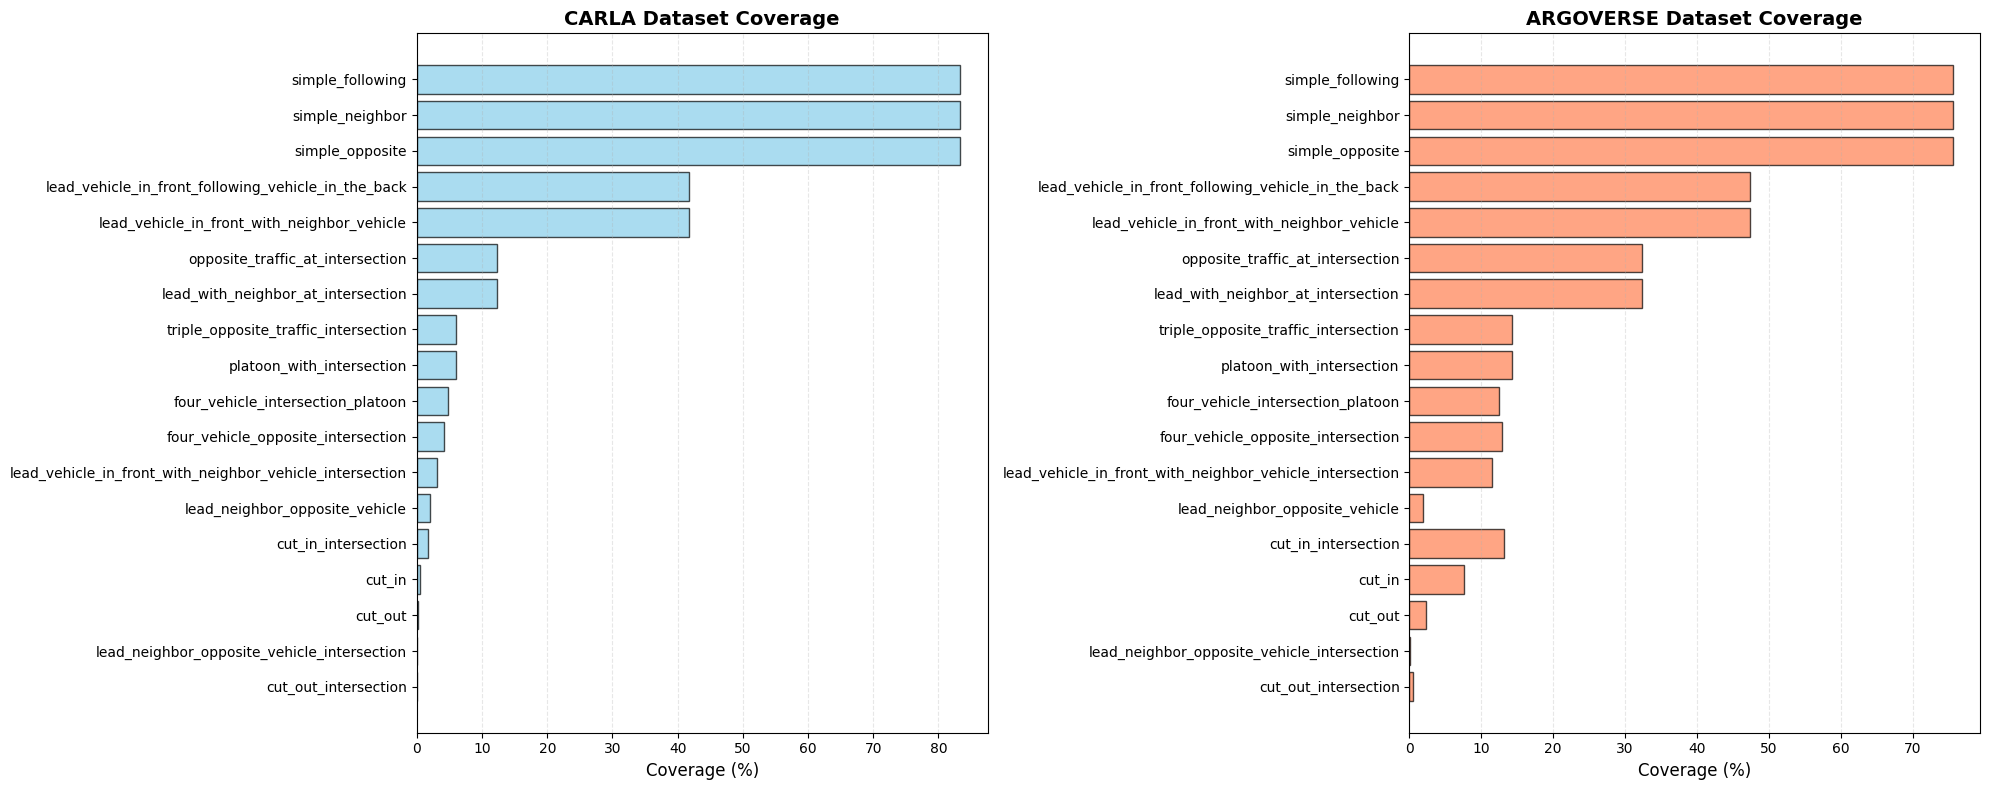

In [13]:
# Side-by-side bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Sort by Carla coverage for consistent ordering
comparison_sorted = comparison_df.sort_values('relative_percentage_carla', ascending=True)

# Carla coverage
axes[0].barh(comparison_sorted['subgraph'], comparison_sorted['relative_percentage_carla'], 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Coverage (%)', fontsize=12)
axes[0].set_title('CARLA Dataset Coverage', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Argoverse coverage
axes[1].barh(comparison_sorted['subgraph'], comparison_sorted['relative_percentage_argo'], 
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Coverage (%)', fontsize=12)
axes[1].set_title('ARGOVERSE Dataset Coverage', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/coverage_comparison_side_by_side.png', dpi=300, bbox_inches='tight')
plt.show()


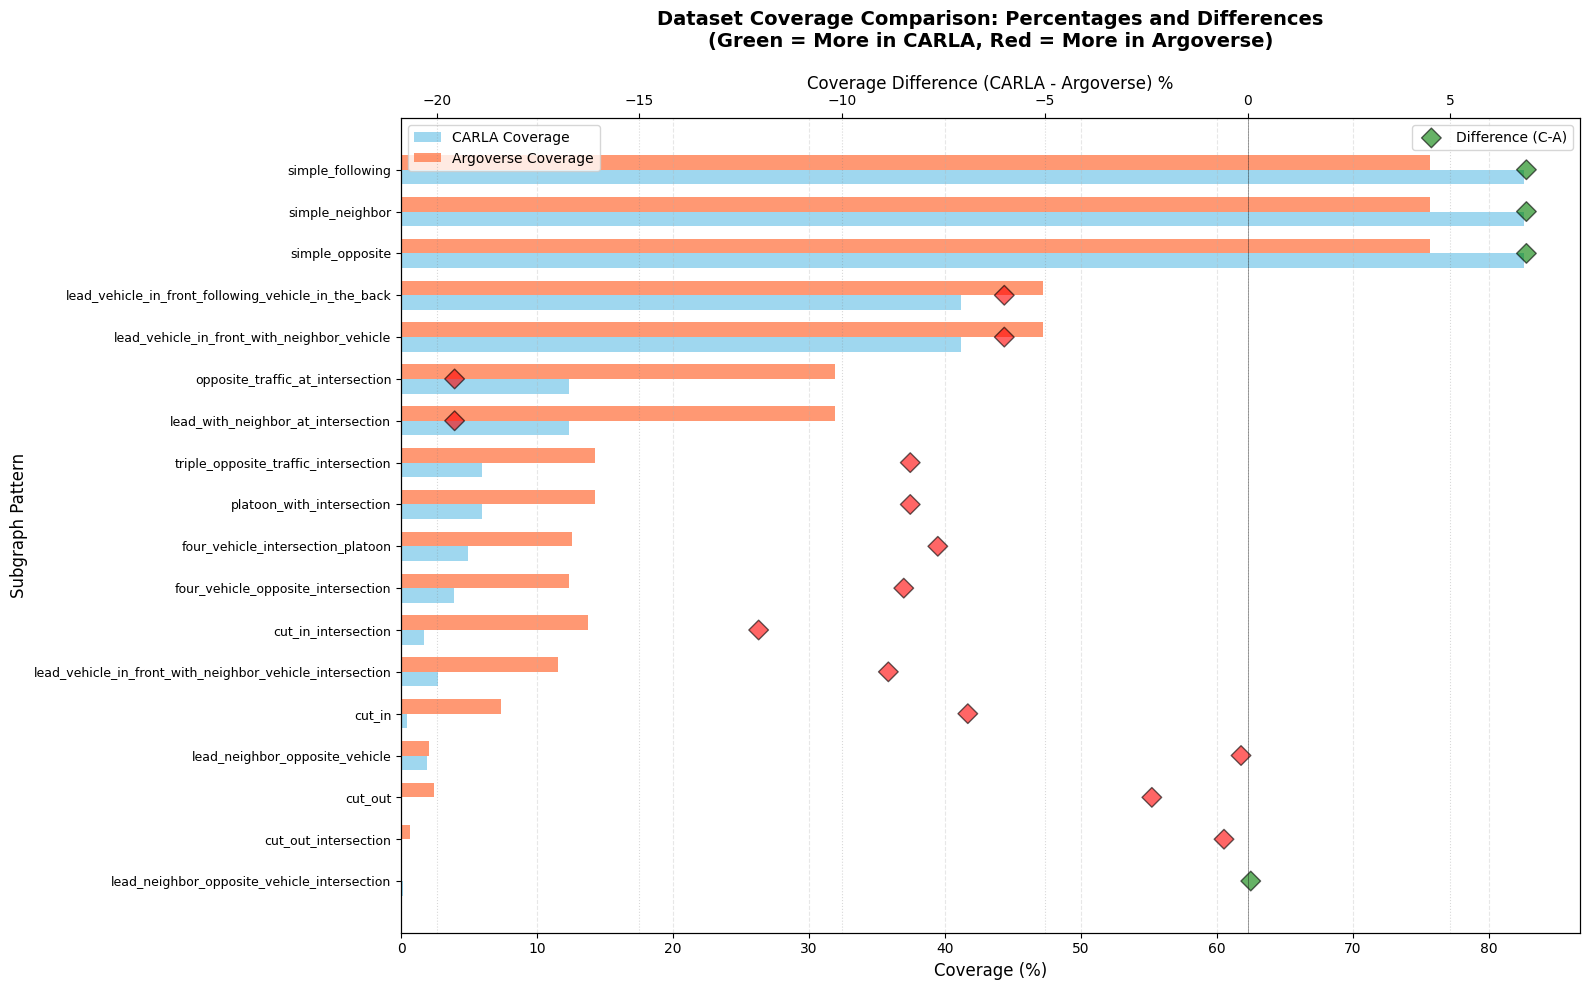

In [16]:
# Dual-axis chart showing coverage percentages and differences
fig, ax1 = plt.subplots(figsize=(16, 10))

# Sort by average coverage for better visualization
comparison_sorted = comparison_df.copy()
comparison_sorted['avg_coverage'] = (comparison_sorted['relative_percentage_carla'] + comparison_sorted['relative_percentage_argo']) / 2
comparison_sorted = comparison_sorted.sort_values('avg_coverage', ascending=True)

x_pos = np.arange(len(comparison_sorted))
width = 0.35

# Left y-axis: Coverage percentages
ax1.barh(x_pos - width/2, comparison_sorted['relative_percentage_carla'], 
         width, label='CARLA Coverage', color='skyblue', alpha=0.8)
ax1.barh(x_pos + width/2, comparison_sorted['relative_percentage_argo'], 
         width, label='Argoverse Coverage', color='coral', alpha=0.8)

ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_ylabel('Subgraph Pattern', fontsize=12)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(comparison_sorted['subgraph'], fontsize=9)
ax1.tick_params(axis='y', labelsize=9)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Right y-axis: Difference
ax2 = ax1.twiny()
colors = ['green' if x > 0 else 'red' for x in comparison_sorted['rel_diff']]
ax2.scatter(comparison_sorted['rel_diff'], x_pos, 
           c=colors, s=100, alpha=0.6, marker='D', 
           label='Difference (C-A)', edgecolors='black', linewidths=1)

# Add vertical line at zero for difference
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax2.set_xlabel('Coverage Difference (CARLA - Argoverse) %', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='x', alpha=0.3, linestyle=':', color='gray')

plt.title('Dataset Coverage Comparison: Percentages and Differences\n(Green = More in CARLA, Red = More in Argoverse)', 
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plots/coverage_comparison_dual_axis.png', dpi=300, bbox_inches='tight')
plt.show()


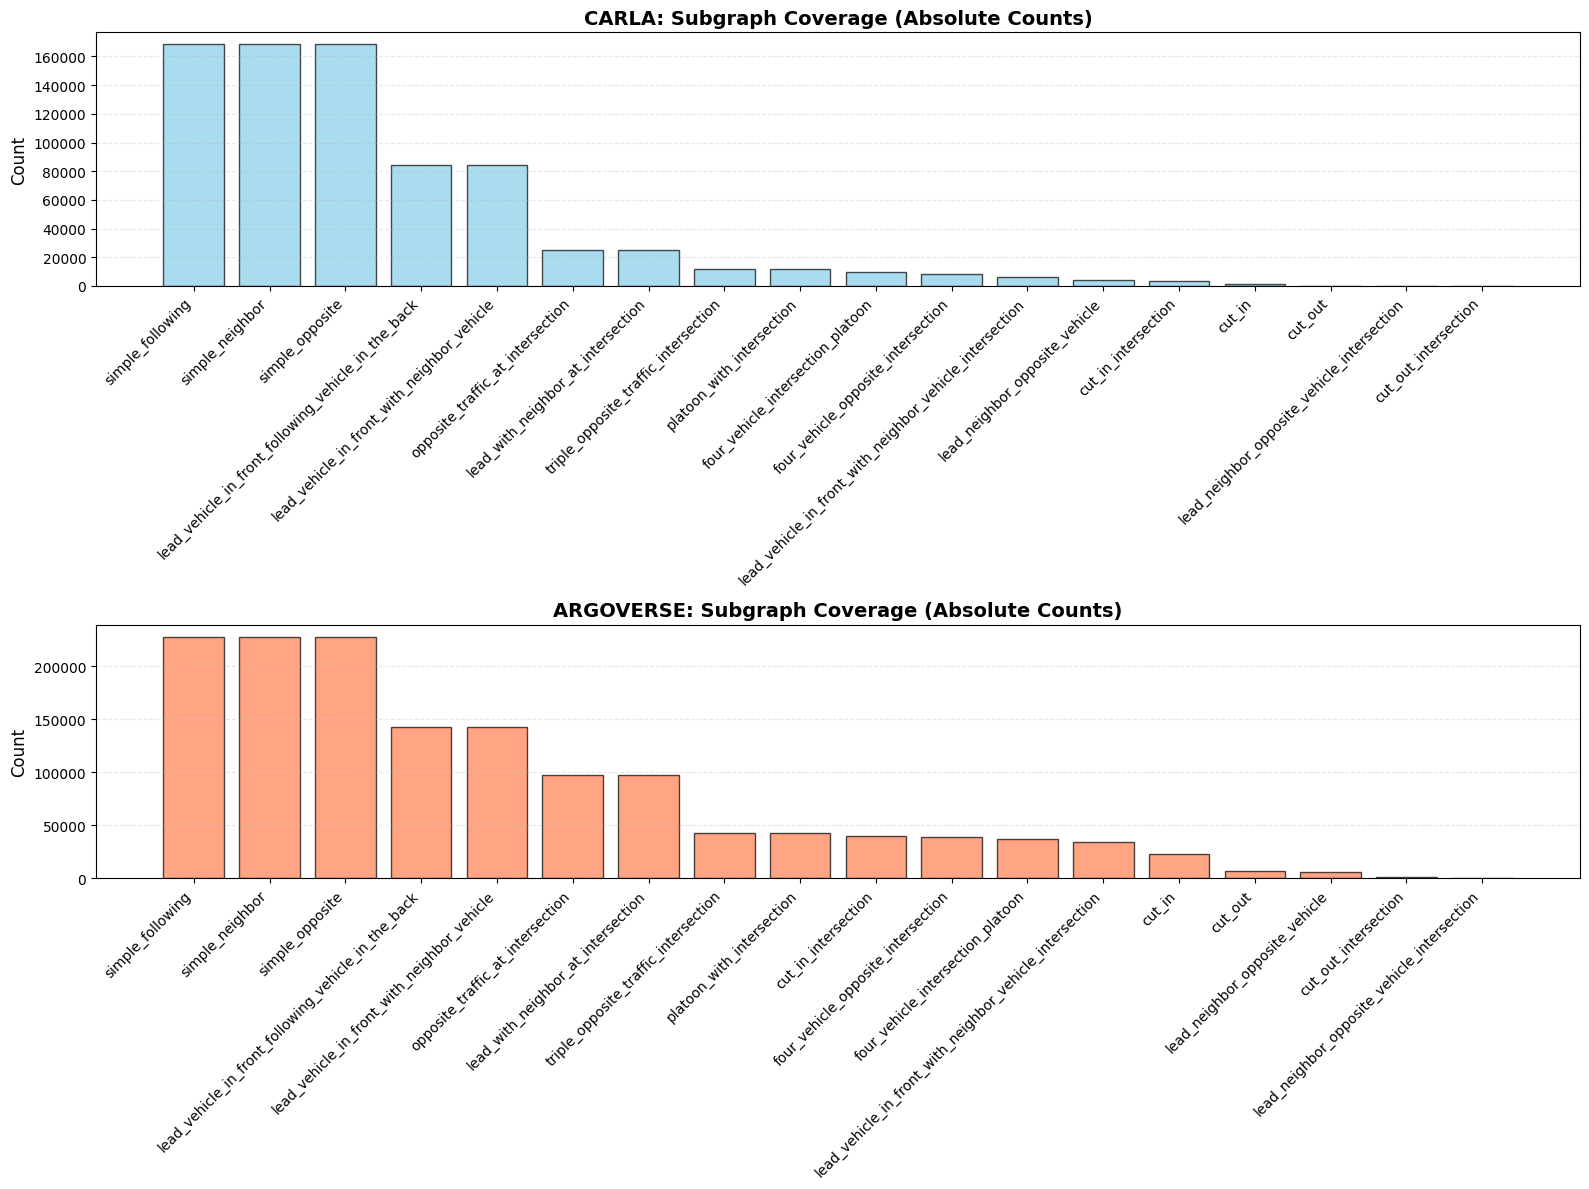

In [14]:
# Bar charts for absolute coverage counts
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Carla bar chart
barchart_df_carla = cov_data_df_carla[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df_carla = barchart_df_carla.sort_values('count', ascending=False)
axes[0].bar(range(len(barchart_df_carla)), barchart_df_carla['count'], 
            color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(barchart_df_carla)))
axes[0].set_xticklabels(barchart_df_carla['scenario'], rotation=45, ha='right')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('CARLA: Subgraph Coverage (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Argoverse bar chart
barchart_df_argo = cov_data_df_argo[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df_argo = barchart_df_argo.sort_values('count', ascending=False)
axes[1].bar(range(len(barchart_df_argo)), barchart_df_argo['count'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(barchart_df_argo)))
axes[1].set_xticklabels(barchart_df_argo['scenario'], rotation=45, ha='right')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('ARGOVERSE: Subgraph Coverage (Absolute Counts)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/subgraph_coverage_barcharts.png', dpi=300, bbox_inches='tight')
plt.show()

## Deep Dive: Speed and Path Analysis Per Scenario

### Analyze speed distributions and driven paths for each subgraph type


In [15]:
def extract_scenario_data_with_roles(cov_df, scenario_name, scenario_pattern, node_match_attrs, edge_match_attrs, max_samples=500):
    """
    Extract node and edge data with role information (a, b, c, etc.) for each actor.
    Role is determined by isomorphism mapping to the subgraph pattern.
    """
    scenario_graph_paths = cov_df[cov_df[scenario_name]].path.to_list()
    
    if len(scenario_graph_paths) > max_samples:
        scenario_graph_paths = random.sample(scenario_graph_paths, max_samples)
    
    node_dfs = []
    edge_dfs = []
    
    for graph_path in tqdm(scenario_graph_paths, desc=f"Loading {scenario_name}"):
        try:
            with open(graph_path, "rb") as file:
                ag_nx = pickle.load(file)
            
            GM = nx.algorithms.isomorphism.DiGraphMatcher(
                ag_nx, scenario_pattern,
                node_match=nx.algorithms.isomorphism.categorical_node_match(node_match_attrs, [None] * len(node_match_attrs)),
                edge_match=nx.algorithms.isomorphism.categorical_edge_match(edge_match_attrs, [None] * len(edge_match_attrs))
            )
            
            mapping = None
            for m in GM.subgraph_isomorphisms_iter():
                mapping = m
                break
            
            if mapping is None:
                continue
            
            node_to_role = {main_node: pattern_node for main_node, pattern_node in mapping.items()}
            node_df, edge_df = make_node_edge_df(ag_nx)
            
            node_df["role"] = node_df["node_id"].map(node_to_role)
            node_df["role"] = node_df["role"].fillna("other")
            
            node_df["path"] = graph_path
            edge_df["path"] = graph_path
            node_df["scenario"] = scenario_name
            edge_df["scenario"] = scenario_name
            
            node_dfs.append(node_df)
            edge_dfs.append(edge_df)
        except Exception as e:
            print(f"Error loading {graph_path}: {e}")
            continue
    
    if len(node_dfs) == 0:
        return None, None
    
    return pd.concat(node_dfs, ignore_index=True), pd.concat(edge_dfs, ignore_index=True)

print("Helper function with role tracking defined.")


Helper function with role tracking defined.


In [16]:
# Select top scenarios for detailed analysis (those with sufficient coverage)
top_scenarios_carla = coverage_carla[coverage_carla['relative_percentage'] >= 5.0]['subgraph'].head(10).tolist()
top_scenarios_argo = coverage_argo[coverage_argo['relative_percentage'] >= 5.0]['subgraph'].head(10).tolist()

print(f"Top scenarios for CARLA analysis: {len(top_scenarios_carla)}")
print(f"Top scenarios for ARGOVERSE analysis: {len(top_scenarios_argo)}")

node_match_attrs = ["actor_type", "lane_change", "is_on_intersection"]
edge_match_attrs = ["edge_type"]

print("\nExtracting CARLA scenario data...")
carla_scenario_nodes = []
carla_scenario_edges = []

for scenario in top_scenarios_carla[:5]:
    scenario_pattern = coverage_graphs[scenario]
    node_df, edge_df = extract_scenario_data_with_roles(
        cov_data_df_carla, scenario, scenario_pattern, 
        node_match_attrs, edge_match_attrs, max_samples=300
    )
    if node_df is not None:
        carla_scenario_nodes.append(node_df)
        carla_scenario_edges.append(edge_df)

if len(carla_scenario_nodes) > 0:
    carla_all_nodes = pd.concat(carla_scenario_nodes, ignore_index=True)
    carla_all_edges = pd.concat(carla_scenario_edges, ignore_index=True)
    print(f"Carla nodes: {len(carla_all_nodes)}, edges: {len(carla_all_edges)}")
else:
    print("No Carla scenario data extracted")

print("\nExtracting ARGOVERSE scenario data...")
argo_scenario_nodes = []
argo_scenario_edges = []

for scenario in top_scenarios_argo[:5]:
    scenario_pattern = coverage_graphs[scenario]
    node_df, edge_df = extract_scenario_data_with_roles(
        cov_data_df_argo, scenario, scenario_pattern,
        node_match_attrs, edge_match_attrs, max_samples=300
    )
    if node_df is not None:
        argo_scenario_nodes.append(node_df)
        argo_scenario_edges.append(edge_df)

if len(argo_scenario_nodes) > 0:
    argo_all_nodes = pd.concat(argo_scenario_nodes, ignore_index=True)
    argo_all_edges = pd.concat(argo_scenario_edges, ignore_index=True)
    print(f"Argo nodes: {len(argo_all_nodes)}, edges: {len(argo_all_edges)}")
else:
    print("No Argoverse scenario data extracted")


Top scenarios for CARLA analysis: 9
Top scenarios for ARGOVERSE analysis: 10

Extracting CARLA scenario data...


Loading simple_following:   0%|          | 0/300 [00:00<?, ?it/s]

Loading simple_opposite: 100%|██████████| 300/300 [00:00<00:00, 436.67it/s]
Loading lead_vehicle_in_front_following_vehicle_in_the_back: 100%|██████████| 300/300 [00:00<00:00, 530.61it/s]
Loading lead_vehicle_in_front_with_neighbor_vehicle: 100%|██████████| 300/300 [00:00<00:00, 398.21it/s]


Carla nodes: 8343, edges: 14176

Extracting ARGOVERSE scenario data...


Loading simple_opposite: 100%|██████████| 300/300 [00:00<00:00, 572.69it/s]
Loading lead_vehicle_in_front_following_vehicle_in_the_back: 100%|██████████| 300/300 [00:00<00:00, 451.14it/s]
Loading lead_vehicle_in_front_with_neighbor_vehicle: 100%|██████████| 300/300 [00:00<00:00, 560.63it/s]

Argo nodes: 10028, edges: 18014


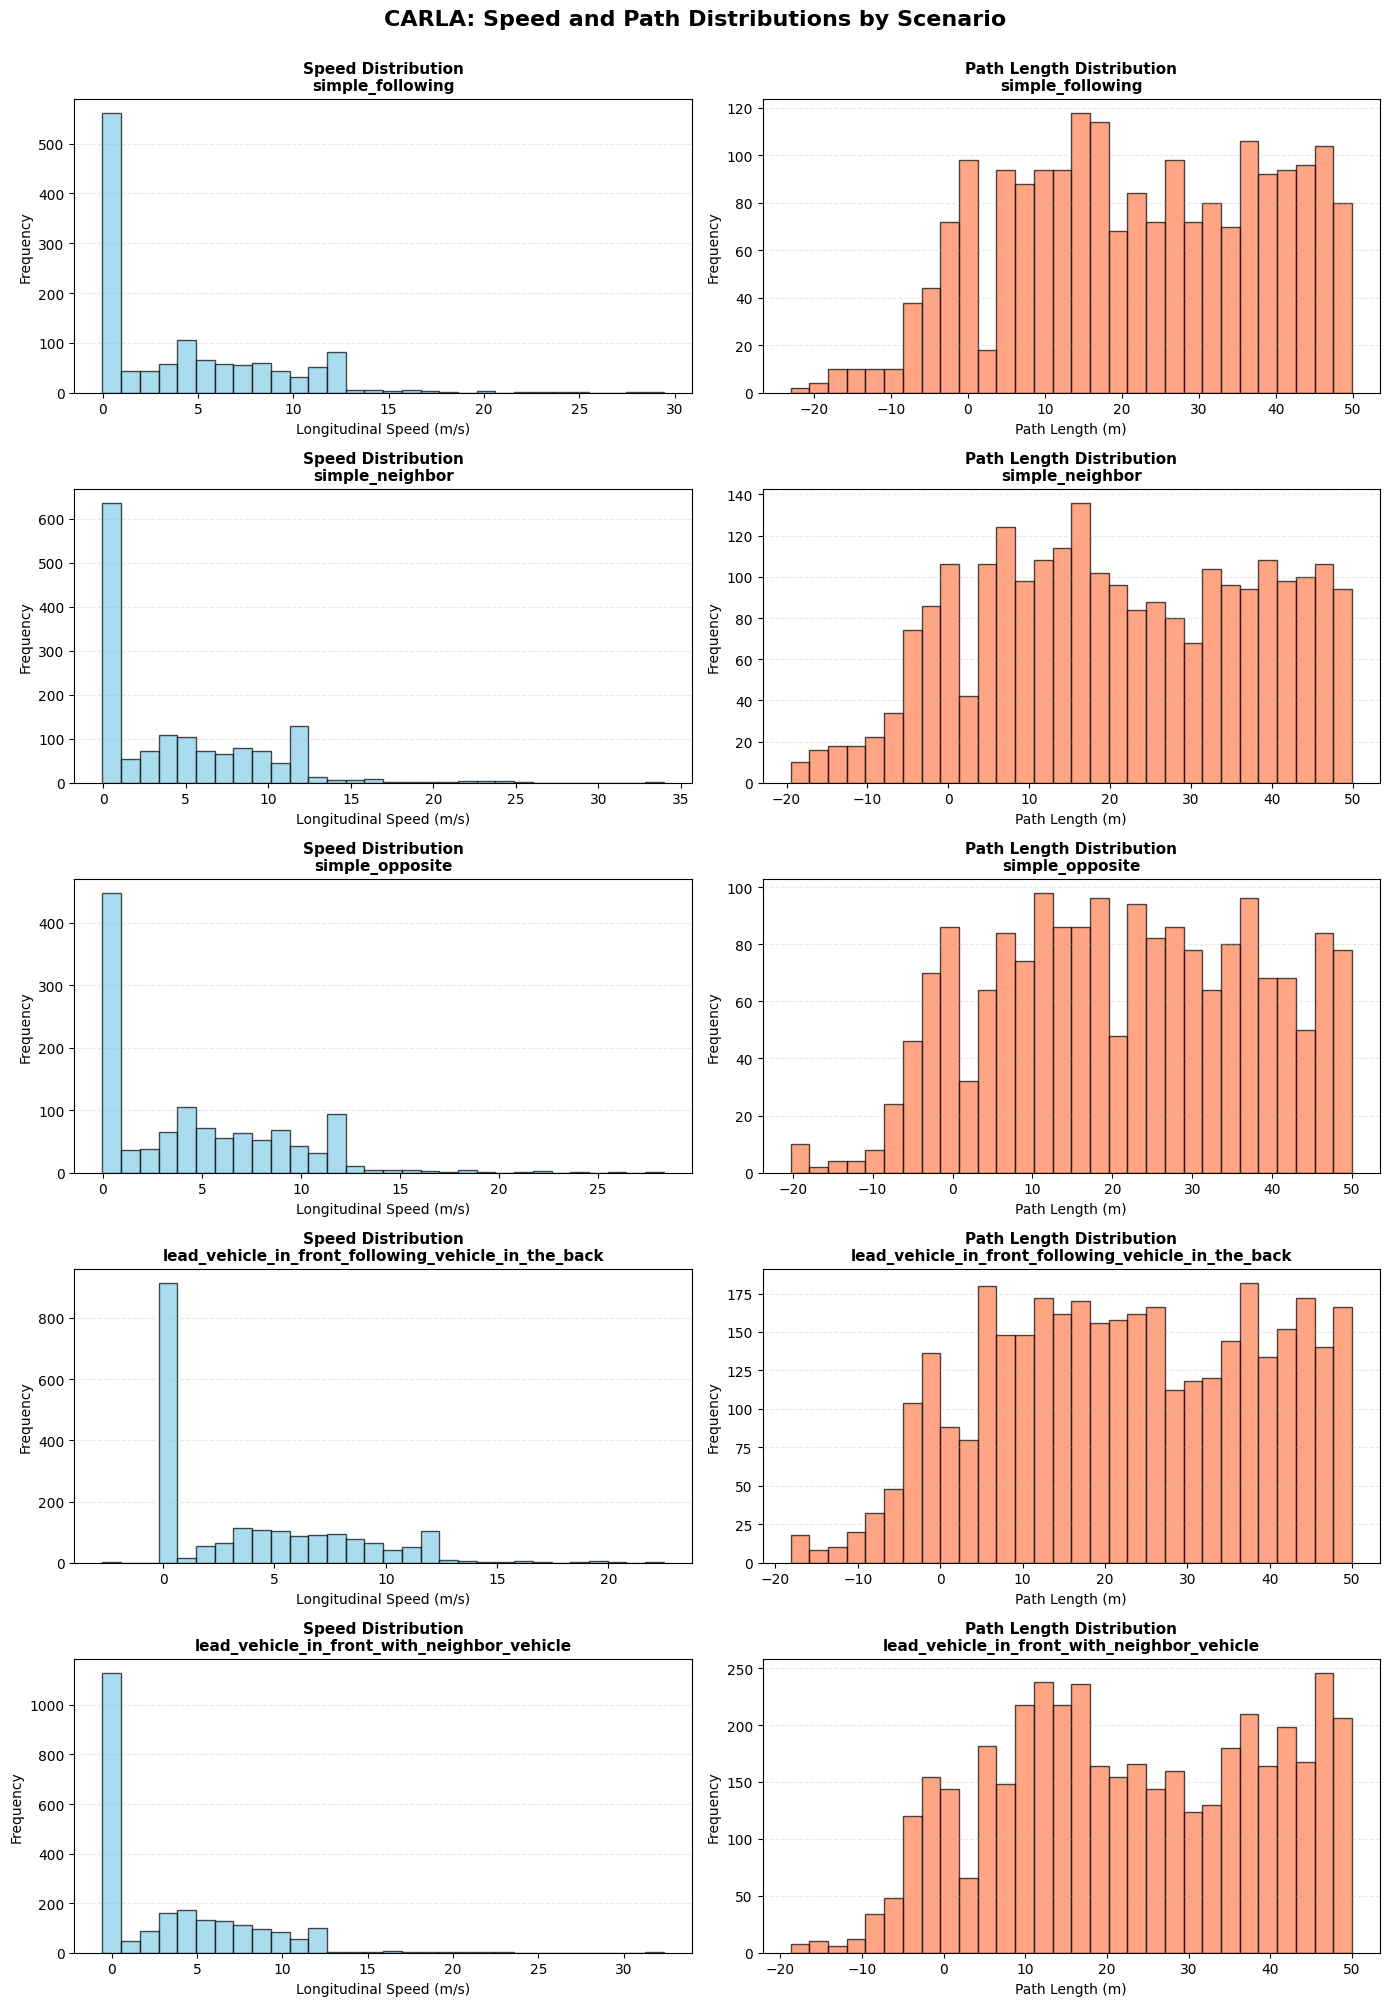

In [17]:
# Speed distribution analysis per scenario - CARLA
if len(carla_scenario_nodes) > 0:
    n_scenarios = len(carla_scenario_nodes)
    fig, axes = plt.subplots(n_scenarios, 2, figsize=(14, 4*n_scenarios))
    
    if n_scenarios == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (node_df, edge_df) in enumerate(zip(carla_scenario_nodes, carla_scenario_edges)):
        scenario_name = node_df['scenario'].iloc[0]
        
        # Speed distribution
        axes[idx, 0].hist(node_df['lon_speed'], bins=30, color='skyblue', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
        axes[idx, 0].set_ylabel('Frequency', fontsize=10)
        axes[idx, 0].set_title(f'Speed Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Path length distribution
        axes[idx, 1].hist(edge_df['path_length'], bins=30, color='coral', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 1].set_xlabel('Path Length (m)', fontsize=10)
        axes[idx, 1].set_ylabel('Frequency', fontsize=10)
        axes[idx, 1].set_title(f'Path Length Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle('CARLA: Speed and Path Distributions by Scenario', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.savefig('plots/carla_speed_path_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No Carla scenario data to plot")


TODO: Why are there negative paths length? 

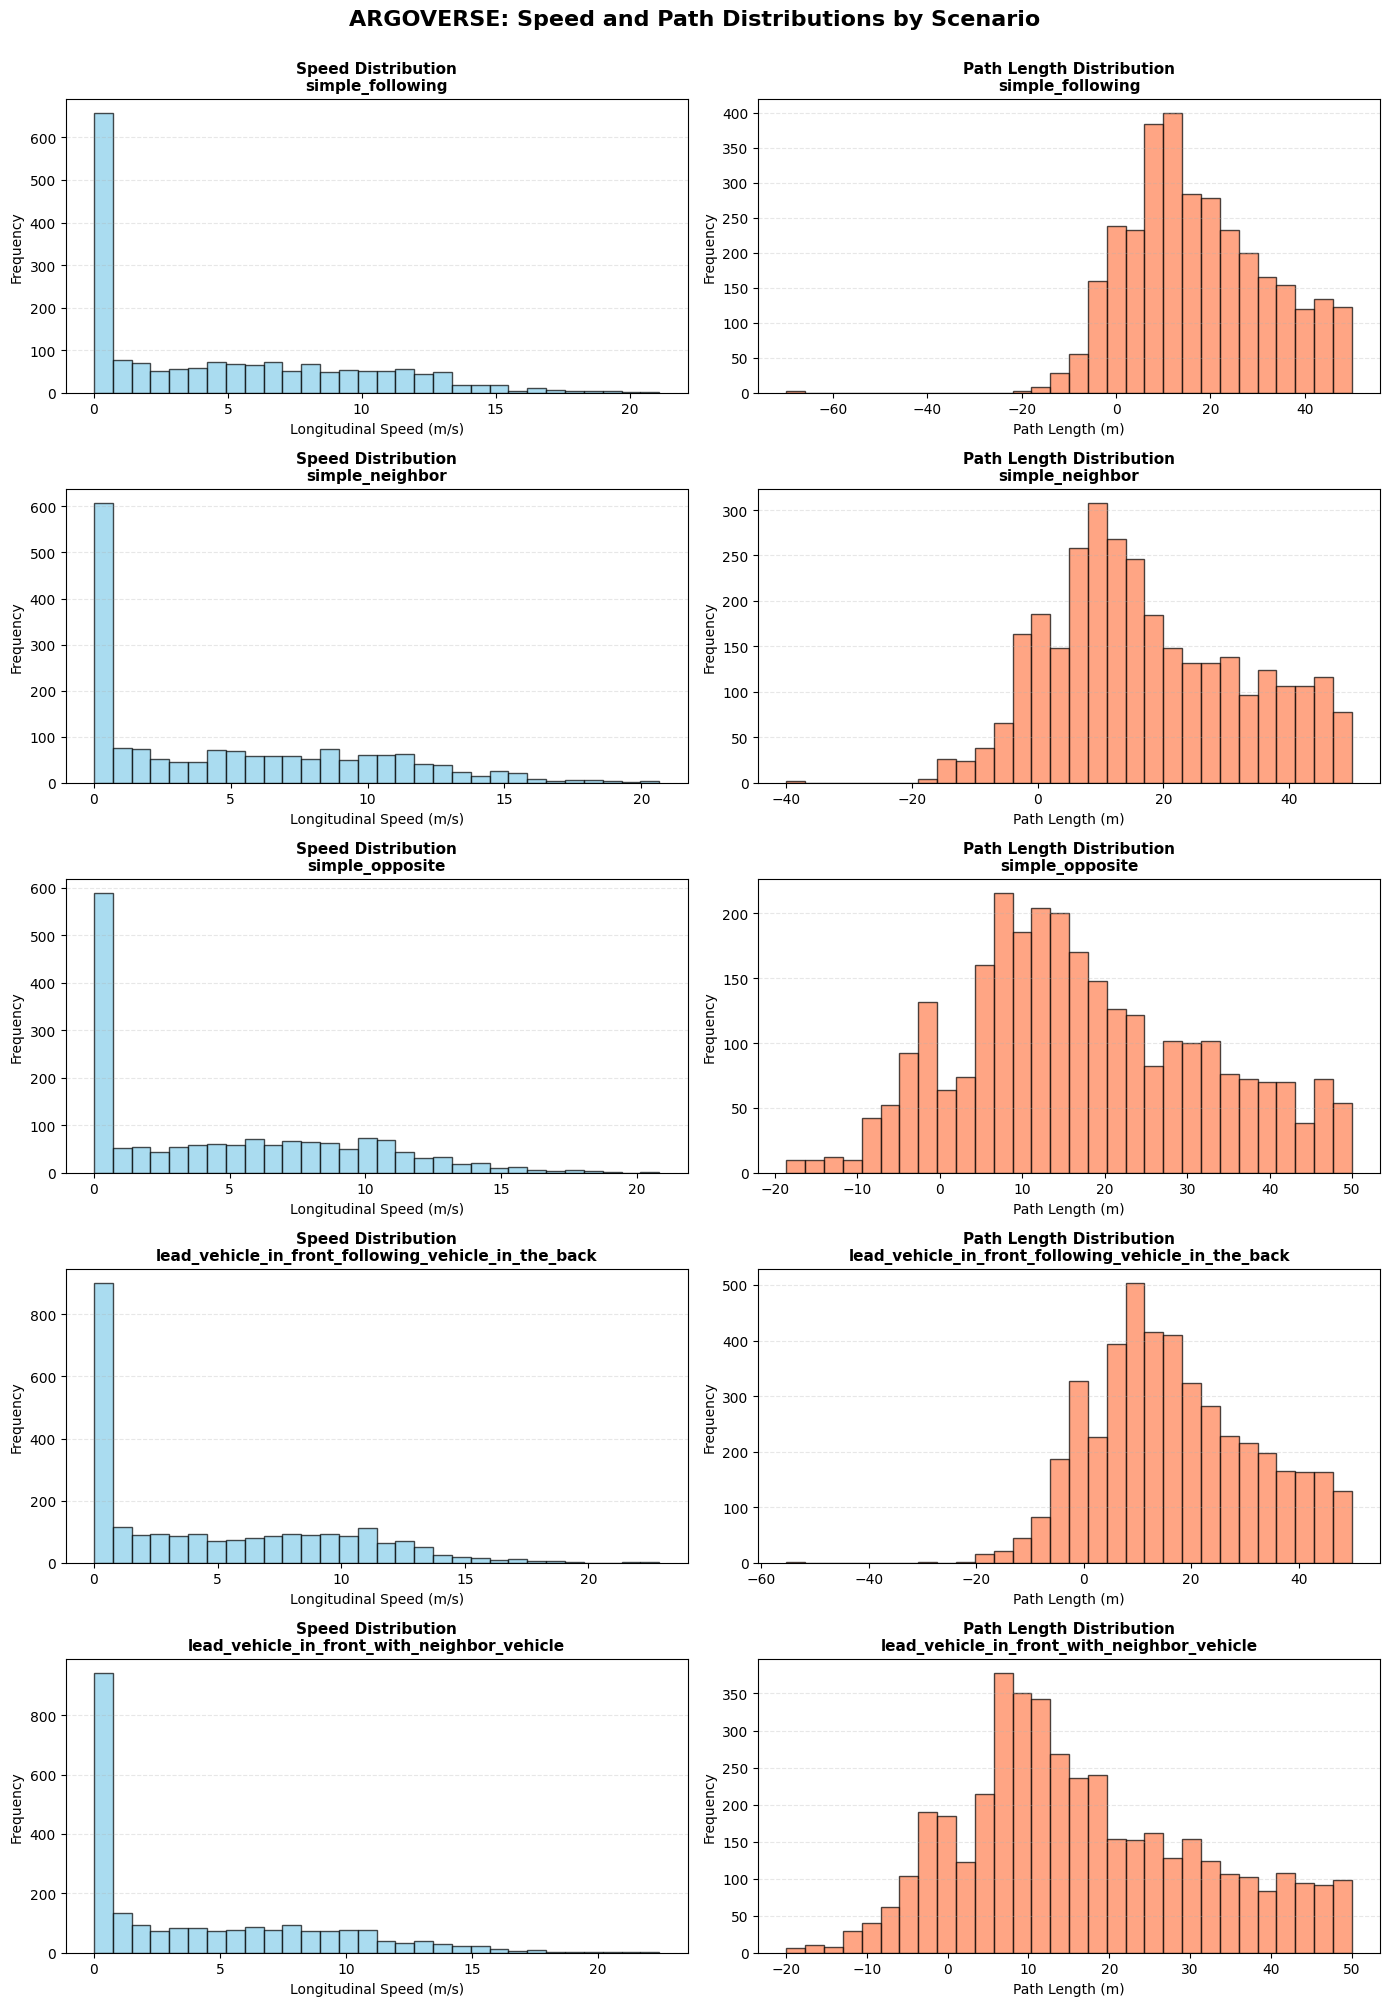

In [18]:
# Speed distribution analysis per scenario - ARGOVERSE
if len(argo_scenario_nodes) > 0:
    n_scenarios = len(argo_scenario_nodes)
    fig, axes = plt.subplots(n_scenarios, 2, figsize=(14, 4*n_scenarios))
    
    if n_scenarios == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (node_df, edge_df) in enumerate(zip(argo_scenario_nodes, argo_scenario_edges)):
        scenario_name = node_df['scenario'].iloc[0]
        
        # Speed distribution
        axes[idx, 0].hist(node_df['lon_speed'], bins=30, color='skyblue', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
        axes[idx, 0].set_ylabel('Frequency', fontsize=10)
        axes[idx, 0].set_title(f'Speed Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Path length distribution
        axes[idx, 1].hist(edge_df['path_length'], bins=30, color='coral', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 1].set_xlabel('Path Length (m)', fontsize=10)
        axes[idx, 1].set_ylabel('Frequency', fontsize=10)
        axes[idx, 1].set_title(f'Path Length Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle('ARGOVERSE: Speed and Path Distributions by Scenario', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.savefig('plots/argo_speed_path_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No Argoverse scenario data to plot")


In [20]:
# Comparative analysis of speed distributions
print("SPEED DISTRIBUTION COMPARISON: Identifying Coverage Holes")

if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    # Compare overlapping scenarios
    common_scenarios = set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & \
                      set([df['scenario'].iloc[0] for df in argo_scenario_nodes])
    
    print(f"\nNumber of common scenarios for comparison: {len(common_scenarios)}")
    
    for scenario in common_scenarios:
        # Get data for this scenario
        carla_data = [df for df in carla_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        argo_data = [df for df in argo_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        
        print(f"\n{'='*60}")
        print(f"Scenario: {scenario}")
        print(f"{'='*60}")
        
        # Speed analysis
        carla_speeds = carla_data['lon_speed'].dropna()
        argo_speeds = argo_data['lon_speed'].dropna()
        
        print(f"\nSpeed Distribution:")
        print(f"  CARLA: mean={carla_speeds.mean():.2f}, std={carla_speeds.std():.2f}, "
              f"min={carla_speeds.min():.2f}, max={carla_speeds.max():.2f}")
        print(f"  ARGO:  mean={argo_speeds.mean():.2f}, std={argo_speeds.std():.2f}, "
              f"min={argo_speeds.min():.2f}, max={argo_speeds.max():.2f}")
        
        # Identify speed holes (ranges present in one but not the other)
        speed_bins = np.linspace(
            min(carla_speeds.min(), argo_speeds.min()),
            max(carla_speeds.max(), argo_speeds.max()),
            20
        )
        
        carla_hist, _ = np.histogram(carla_speeds, bins=speed_bins)
        argo_hist, _ = np.histogram(argo_speeds, bins=speed_bins)
        
        # Find bins with significant coverage in one but not the other
        threshold = 0.01  # 1% of max count
        carla_threshold = threshold * carla_hist.max()
        argo_threshold = threshold * argo_hist.max()
        
        holes_in_carla = np.where((argo_hist > argo_threshold) & (carla_hist < carla_threshold))[0]
        holes_in_argo = np.where((carla_hist > carla_threshold) & (argo_hist < argo_threshold))[0]
        
        if len(holes_in_carla) > 0:
            print(f"\n  Speed HOLES in CARLA (present in Argo):")
            for idx in holes_in_carla:
                print(f"    Range: [{speed_bins[idx]:.1f}, {speed_bins[idx+1]:.1f}] m/s")
        
        if len(holes_in_argo) > 0:
            print(f"\n  Speed HOLES in ARGOVERSE (present in Carla):")
            for idx in holes_in_argo:
                print(f"    Range: [{speed_bins[idx]:.1f}, {speed_bins[idx+1]:.1f}] m/s")
        
        if len(holes_in_carla) == 0 and len(holes_in_argo) == 0:
            print(f"\n  No significant speed coverage holes detected")
else:
    print("\nInsufficient data for comparison")

print("\n" + "="*80)


SPEED DISTRIBUTION COMPARISON: Identifying Coverage Holes

Number of common scenarios for comparison: 5

Scenario: simple_following

Speed Distribution:
  CARLA: mean=4.16, std=4.77, min=-0.01, max=29.43
  ARGO:  mean=4.68, std=4.87, min=0.00, max=21.11

  Speed HOLES in CARLA (present in Argo):
    Range: [13.9, 15.5] m/s
    Range: [17.0, 18.6] m/s
    Range: [18.6, 20.1] m/s

Scenario: lead_vehicle_in_front_with_neighbor_vehicle

Speed Distribution:
  CARLA: mean=3.37, std=4.16, min=-0.54, max=32.36
  ARGO:  mean=4.24, std=4.78, min=0.00, max=22.44

  Speed HOLES in CARLA (present in Argo):
    Range: [13.3, 15.0] m/s
    Range: [15.0, 16.8] m/s
    Range: [16.8, 18.5] m/s

Scenario: simple_neighbor

Speed Distribution:
  CARLA: mean=4.36, std=4.92, min=-0.05, max=33.96
  ARGO:  mean=4.92, std=4.94, min=0.00, max=20.65

  Speed HOLES in CARLA (present in Argo):
    Range: [16.1, 17.9] m/s
    Range: [17.9, 19.6] m/s

  Speed HOLES in ARGOVERSE (present in Carla):
    Range: [21.4, 2

In [21]:
# Comparative analysis of path length distributions
print("="*80)
print("PATH LENGTH DISTRIBUTION COMPARISON: Identifying Coverage Holes")
print("="*80)

if len(carla_scenario_edges) > 0 and len(argo_scenario_edges) > 0:
    # Compare overlapping scenarios
    common_scenarios = set([df['scenario'].iloc[0] for df in carla_scenario_edges]) & \
                      set([df['scenario'].iloc[0] for df in argo_scenario_edges])
    
    print(f"\nNumber of common scenarios for comparison: {len(common_scenarios)}")
    
    for scenario in common_scenarios:
        # Get data for this scenario
        carla_data = [df for df in carla_scenario_edges if df['scenario'].iloc[0] == scenario][0]
        argo_data = [df for df in argo_scenario_edges if df['scenario'].iloc[0] == scenario][0]
        
        print(f"\n{'='*60}")
        print(f"Scenario: {scenario}")
        print(f"{'='*60}")
        
        # Path length analysis
        carla_paths = carla_data['path_length'].dropna()
        argo_paths = argo_data['path_length'].dropna()
        
        print(f"\nPath Length Distribution:")
        print(f"  CARLA: mean={carla_paths.mean():.2f}, std={carla_paths.std():.2f}, "
              f"min={carla_paths.min():.2f}, max={carla_paths.max():.2f}")
        print(f"  ARGO:  mean={argo_paths.mean():.2f}, std={argo_paths.std():.2f}, "
              f"min={argo_paths.min():.2f}, max={argo_paths.max():.2f}")
        
        # Identify path length holes
        path_bins = np.linspace(
            min(carla_paths.min(), argo_paths.min()),
            max(carla_paths.max(), argo_paths.max()),
            20
        )
        
        carla_hist, _ = np.histogram(carla_paths, bins=path_bins)
        argo_hist, _ = np.histogram(argo_paths, bins=path_bins)
        
        threshold = 0.01
        carla_threshold = threshold * carla_hist.max()
        argo_threshold = threshold * argo_hist.max()
        
        holes_in_carla = np.where((argo_hist > argo_threshold) & (carla_hist < carla_threshold))[0]
        holes_in_argo = np.where((carla_hist > carla_threshold) & (argo_hist < argo_threshold))[0]
        
        if len(holes_in_carla) > 0:
            print(f"\n  Path Length HOLES in CARLA (present in Argo):")
            for idx in holes_in_carla:
                print(f"    Range: [{path_bins[idx]:.1f}, {path_bins[idx+1]:.1f}] m")
        
        if len(holes_in_argo) > 0:
            print(f"\n  Path Length HOLES in ARGOVERSE (present in Carla):")
            for idx in holes_in_argo:
                print(f"    Range: [{path_bins[idx]:.1f}, {path_bins[idx+1]:.1f}] m")
        
        if len(holes_in_carla) == 0 and len(holes_in_argo) == 0:
            print(f"\n  No significant path length coverage holes detected")
else:
    print("\nInsufficient data for comparison")

print("\n" + "="*80)


PATH LENGTH DISTRIBUTION COMPARISON: Identifying Coverage Holes

Number of common scenarios for comparison: 5

Scenario: simple_following

Path Length Distribution:
  CARLA: mean=21.87, std=16.82, min=-23.05, max=49.92
  ARGO:  mean=17.46, std=14.88, min=-69.86, max=49.96

  Path Length HOLES in ARGOVERSE (present in Carla):
    Range: [-25.7, -19.4] m

Scenario: lead_vehicle_in_front_with_neighbor_vehicle

Path Length Distribution:
  CARLA: mean=22.88, std=16.42, min=-18.75, max=50.00
  ARGO:  mean=16.60, std=14.78, min=-19.95, max=49.99

  No significant path length coverage holes detected

Scenario: simple_neighbor

Path Length Distribution:
  CARLA: mean=20.85, std=17.02, min=-19.50, max=49.88
  ARGO:  mean=17.29, std=15.28, min=-39.98, max=49.97

  Path Length HOLES in ARGOVERSE (present in Carla):
    Range: [-21.0, -16.3] m

Scenario: lead_vehicle_in_front_following_vehicle_in_the_back

Path Length Distribution:
  CARLA: mean=22.44, std=16.34, min=-18.16, max=49.99
  ARGO:  mean

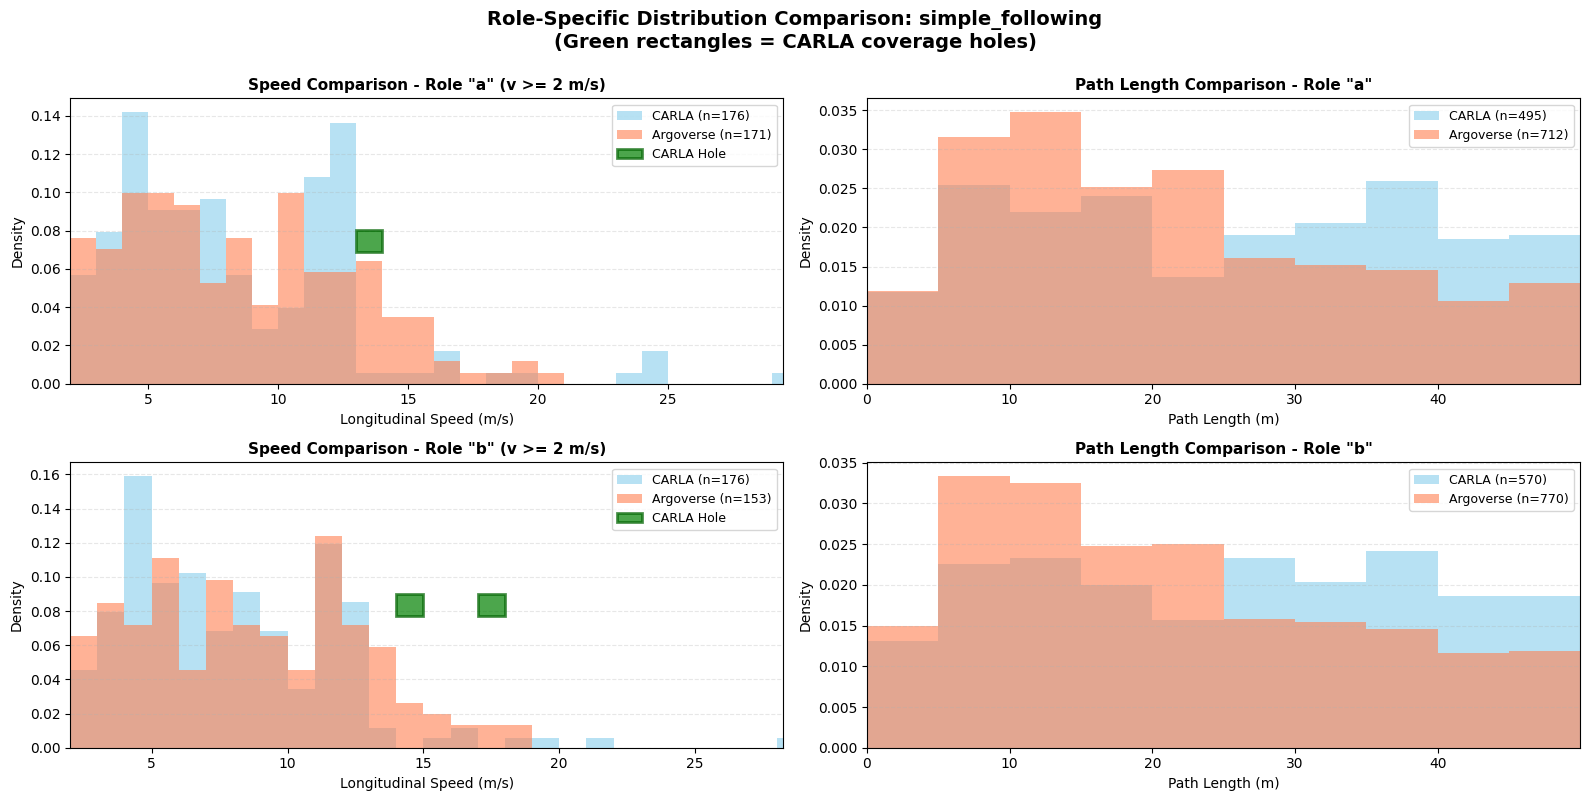

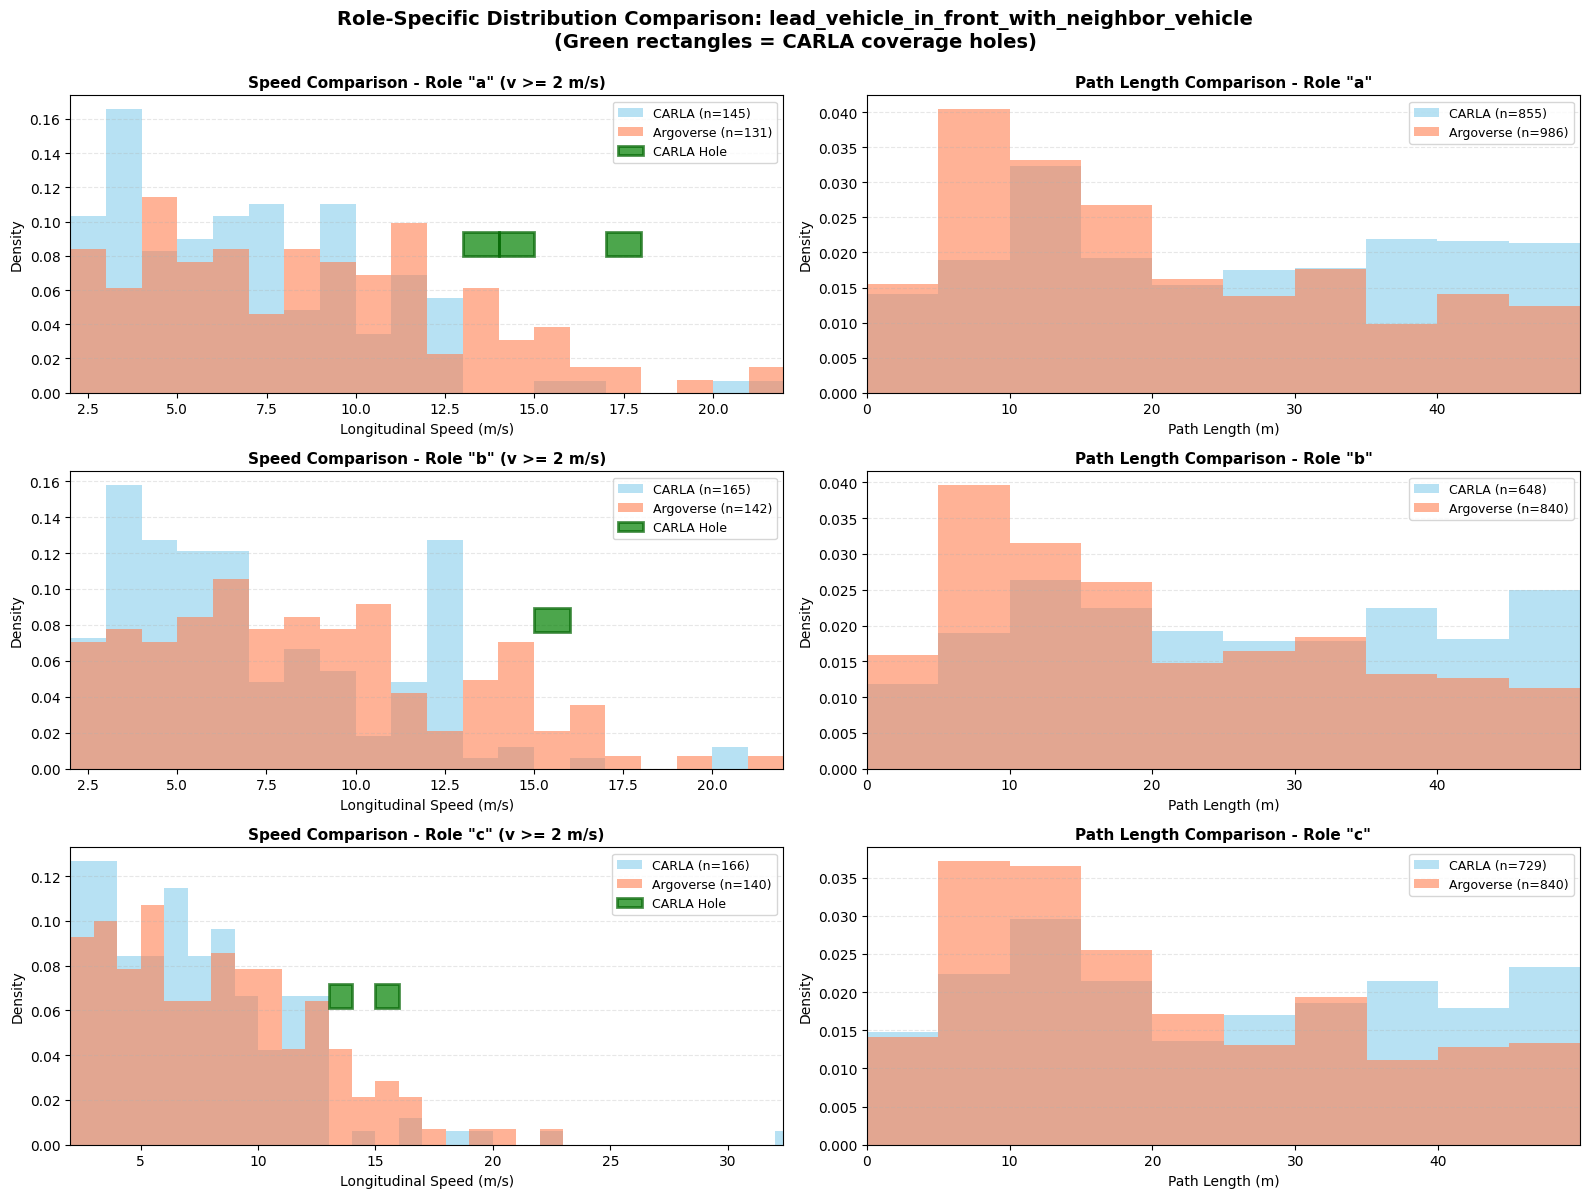

In [22]:
# Visualize speed distributions BY ROLE for common scenarios with hole highlighting
if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    common_scenarios = list(set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & 
                           set([df['scenario'].iloc[0] for df in argo_scenario_nodes]))
    
    if len(common_scenarios) > 0:
        # Limit to first 2 scenarios for readability (since we'll have multiple roles per scenario)
        n_scenarios = min(len(common_scenarios), 2)
        
        for scenario in common_scenarios[:n_scenarios]:
            # Get data for this scenario
            carla_node_data = [df for df in carla_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
            argo_node_data = [df for df in argo_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
            
            # Get all roles in this subgraph pattern (excluding 'other')
            all_roles = sorted([r for r in carla_node_data['role'].unique() if r != 'other'])
            
            if len(all_roles) == 0:
                print(f"No roles found for scenario {scenario}")
                continue
            
            # Create subplot grid: rows = roles, cols = speed (left) and path (right)
            n_roles = len(all_roles)
            fig, axes = plt.subplots(n_roles, 2, figsize=(16, 4*n_roles))
            
            # Handle single role case
            if n_roles == 1:
                axes = axes.reshape(1, -1)
            
            for role_idx, role in enumerate(all_roles):
                # Filter data for this specific role
                carla_role_data = carla_node_data[carla_node_data['role'] == role]
                argo_role_data = argo_node_data[argo_node_data['role'] == role]
                
                # === SPEED COMPARISON FOR THIS ROLE ===
                # Filter out low speeds (< 2 m/s)
                carla_speed = carla_role_data[carla_role_data['lon_speed'] >= 2.0]['lon_speed']
                argo_speed = argo_role_data[argo_role_data['lon_speed'] >= 2.0]['lon_speed']
                
                if len(carla_speed) == 0 or len(argo_speed) == 0:
                    axes[role_idx, 0].text(0.5, 0.5, f'Insufficient data for role "{role}"', 
                                          ha='center', va='center', fontsize=12)
                    axes[role_idx, 0].set_xlim(0, 1)
                    axes[role_idx, 0].set_ylim(0, 1)
                    axes[role_idx, 0].axis('off')
                else:
                    # Use fixed bins: start at 2.0, step by 1.0 m/s
                    combined_max = max(carla_speed.max(), argo_speed.max())
                    bin_edges_speed = np.arange(2.0, combined_max + 1.0, 1.0)  # Fixed 1.0 m/s bins
                    combined_min = 2.0
                    
                    # Calculate histograms using the same bins
                    argo_hist, _ = np.histogram(argo_speed, bins=bin_edges_speed, density=True)
                    carla_hist, _ = np.histogram(carla_speed, bins=bin_edges_speed, density=True)
                    
                    # Plot histograms using the same bin edges (density=True means each integrates to 1)
                    axes[role_idx, 0].hist(carla_speed, bins=bin_edges_speed, alpha=0.6, 
                                          label=f'CARLA (n={len(carla_speed)})', color='skyblue', density=True)
                    axes[role_idx, 0].hist(argo_speed, bins=bin_edges_speed, alpha=0.6, 
                                          label=f'Argoverse (n={len(argo_speed)})', color='coral', density=True)
                    
                    # Get y-limits AFTER both histograms are plotted
                    axes[role_idx, 0].set_xlim(combined_min, combined_max)
                    ylim = axes[role_idx, 0].get_ylim()
                    y_middle = ylim[1] * 0.5
                    rect_height = ylim[1] * 0.08
                    
                    # Define thresholds for hole detection
                    # High threshold: Argoverse has meaningful data (absolute density value)
                    high_threshold = 0.01  # Minimum density to consider Argo has data
                    # Low threshold: CARLA has very little data (relative comparison)
                    # Mark as hole if CARLA has less than 10% of what Argoverse has
                    
                    # Mark each bin where Argo is high AND CARLA is low (coverage holes)
                    hole_added = False
                    for i in range(len(bin_edges_speed) - 1):  # Iterate through bins
                        # Check if this bin is a hole:
                        # 1. Argoverse has meaningful data (> threshold)
                        # 2. CARLA has much less (< 10% of Argo's density)
                        if argo_hist[i] >= high_threshold and carla_hist[i] < (argo_hist[i] * 0.1):
                            x_start = bin_edges_speed[i]
                            bin_width = bin_edges_speed[i+1] - bin_edges_speed[i]
                            
                            if not hole_added:
                                axes[role_idx, 0].add_patch(plt.Rectangle((x_start, y_middle - rect_height/2),
                                                                         bin_width, rect_height,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2,
                                                                         label='CARLA Hole', zorder=10))
                                hole_added = True
                            else:
                                axes[role_idx, 0].add_patch(plt.Rectangle((x_start, y_middle - rect_height/2),
                                                                         bin_width, rect_height,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2, zorder=10))
                    
                    axes[role_idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
                    axes[role_idx, 0].set_ylabel('Density', fontsize=10)
                    axes[role_idx, 0].set_title(f'Speed Comparison - Role "{role}" (v >= 2 m/s)', 
                                               fontsize=11, fontweight='bold')
                    axes[role_idx, 0].legend(loc='best', fontsize=9)
                    axes[role_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
                
                # === PATH LENGTH COMPARISON FOR THIS ROLE ===
                # Get edge data involving this role (edges where source or target is this role)
                carla_role_node_ids = carla_role_data['node_id'].tolist()
                argo_role_node_ids = argo_role_data['node_id'].tolist()
                
                # Get corresponding edge data from the scenario edges
                carla_edge_data = [df for df in carla_scenario_edges if df['scenario'].iloc[0] == scenario][0]
                argo_edge_data = [df for df in argo_scenario_edges if df['scenario'].iloc[0] == scenario][0]
                
                # Filter edges where source node has this role
                carla_role_edges = carla_edge_data[carla_edge_data['source'].isin(carla_role_node_ids)]
                argo_role_edges = argo_edge_data[argo_edge_data['source'].isin(argo_role_node_ids)]
                
                if len(carla_role_edges) == 0 or len(argo_role_edges) == 0:
                    axes[role_idx, 1].text(0.5, 0.5, f'Insufficient edge data for role "{role}"', 
                                          ha='center', va='center', fontsize=12)
                    axes[role_idx, 1].set_xlim(0, 1)
                    axes[role_idx, 1].set_ylim(0, 1)
                    axes[role_idx, 1].axis('off')
                else:
                    # Use fixed bins: step by 5.0 meters for path length
                    combined_min_path = 0.0
                    combined_max_path = max(carla_role_edges['path_length'].max(), argo_role_edges['path_length'].max())
                    bin_edges_path = np.arange(0.0, combined_max_path + 5.0, 5.0)  # Fixed 5.0 m bins
                    
                    # Calculate histograms using the same bins
                    argo_hist_path, _ = np.histogram(argo_role_edges['path_length'], bins=bin_edges_path, density=True)
                    carla_hist_path, _ = np.histogram(carla_role_edges['path_length'], bins=bin_edges_path, density=True)
                    
                    # Plot histograms using the same bin edges (density=True means each integrates to 1)
                    axes[role_idx, 1].hist(carla_role_edges['path_length'], bins=bin_edges_path, alpha=0.6, 
                                          label=f'CARLA (n={len(carla_role_edges)})', color='skyblue', density=True)
                    axes[role_idx, 1].hist(argo_role_edges['path_length'], bins=bin_edges_path, alpha=0.6, 
                                          label=f'Argoverse (n={len(argo_role_edges)})', color='coral', density=True)
                    
                    # Get y-limits AFTER both histograms are plotted
                    axes[role_idx, 1].set_xlim(combined_min_path, combined_max_path)
                    ylim_path = axes[role_idx, 1].get_ylim()
                    y_middle_path = ylim_path[1] * 0.5
                    rect_height_path = ylim_path[1] * 0.08
                    
                    # Define thresholds for hole detection
                    # High threshold: Argoverse has meaningful data (absolute density value)
                    high_threshold_path = 0.01  # Minimum density to consider Argo has data
                    # Mark as hole if CARLA has less than 10% of what Argoverse has
                    
                    # Mark each bin where Argo is high AND CARLA is low (coverage holes)
                    hole_added_path = False
                    for i in range(len(bin_edges_path) - 1):  # Iterate through bins
                        # Check if this bin is a hole:
                        # 1. Argoverse has meaningful data (> threshold)
                        # 2. CARLA has much less (< 10% of Argo's density)
                        if argo_hist_path[i] >= high_threshold_path and carla_hist_path[i] < (argo_hist_path[i] * 0.1):
                            x_start_path = bin_edges_path[i]
                            bin_width_path = bin_edges_path[i+1] - bin_edges_path[i]
                            
                            if not hole_added_path:
                                axes[role_idx, 1].add_patch(plt.Rectangle((x_start_path, y_middle_path - rect_height_path/2),
                                                                         bin_width_path, rect_height_path,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2,
                                                                         label='CARLA Hole', zorder=10))
                                hole_added_path = True
                            else:
                                axes[role_idx, 1].add_patch(plt.Rectangle((x_start_path, y_middle_path - rect_height_path/2),
                                                                         bin_width_path, rect_height_path,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2, zorder=10))
                    
                    axes[role_idx, 1].set_xlabel('Path Length (m)', fontsize=10)
                    axes[role_idx, 1].set_ylabel('Density', fontsize=10)
                    axes[role_idx, 1].set_title(f'Path Length Comparison - Role "{role}"', 
                                               fontsize=11, fontweight='bold')
                    axes[role_idx, 1].legend(loc='best', fontsize=9)
                    axes[role_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
            
            plt.suptitle(f'Role-Specific Distribution Comparison: {scenario}\n(Green rectangles = CARLA coverage holes)', 
                         fontsize=14, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.savefig(f'plots/role_comparison_{scenario.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
            plt.show()
    else:
        print("No common scenarios for visualization")
else:
    print("Insufficient data for visualization")


In [ ]:
# Export Speed/Path Distribution Holes to CSV
print(f"\n{'='*80}")
print("2. Exporting speed and path distribution holes...")
print(f"{'='*80}\n")

speed_holes_data = []
path_holes_data = []

if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    common_scenarios = list(set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & 
                           set([df['scenario'].iloc[0] for df in argo_scenario_nodes]))
    
    for scenario in common_scenarios:
        print(f"  Processing scenario: {scenario}")
        
        # Get data for this scenario
        carla_node_data = [df for df in carla_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        argo_node_data = [df for df in argo_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        
        # Get all roles
        all_roles = sorted([r for r in carla_node_data['role'].unique() if r != 'other'])
        
        for role in all_roles:
            # === SPEED HOLES ===
            carla_role_data = carla_node_data[carla_node_data['role'] == role]
            argo_role_data = argo_node_data[argo_node_data['role'] == role]
            
            carla_speed = carla_role_data[carla_role_data['lon_speed'] >= 2.0]['lon_speed']
            argo_speed = argo_role_data[argo_role_data['lon_speed'] >= 2.0]['lon_speed']
            
            if len(carla_speed) > 0 and len(argo_speed) > 0:
                # Calculate histograms
                combined_max = max(carla_speed.max(), argo_speed.max())
                bin_edges_speed = np.arange(2.0, combined_max + 1.0, 1.0)
                
                argo_hist, _ = np.histogram(argo_speed, bins=bin_edges_speed, density=True)
                carla_hist, _ = np.histogram(carla_speed, bins=bin_edges_speed, density=True)
                
                # Find holes
                high_threshold = 0.01
                for i in range(len(bin_edges_speed) - 1):
                    if argo_hist[i] >= high_threshold and carla_hist[i] < (argo_hist[i] * 0.1):
                        # This bin is a hole - get Argoverse data in this range
                        speed_min = bin_edges_speed[i]
                        speed_max = bin_edges_speed[i+1]
                        
                        # Get Argoverse graphs with speeds in this range for this role
                        argo_in_range = argo_role_data[
                            (argo_role_data['lon_speed'] >= speed_min) & 
                            (argo_role_data['lon_speed'] < speed_max)
                        ]
                        
                        for _, row in argo_in_range.iterrows():
                            speed_holes_data.append({
                                'scenario': scenario,
                                'role': role,
                                'speed_range_min': speed_min,
                                'speed_range_max': speed_max,
                                'argoverse_graph_path': row['path'],
                                'argoverse_node_id': row['node_id'],
                                'actual_speed': row['lon_speed'],
                                'argo_density': argo_hist[i],
                                'carla_density': carla_hist[i],
                                'density_gap': argo_hist[i] - carla_hist[i]
                            })
            
            # === PATH LENGTH HOLES ===
            carla_role_node_ids = carla_role_data['node_id'].tolist()
            argo_role_node_ids = argo_role_data['node_id'].tolist()
            
            carla_edge_data = [df for df in carla_scenario_edges if df['scenario'].iloc[0] == scenario][0]
            argo_edge_data = [df for df in argo_scenario_edges if df['scenario'].iloc[0] == scenario][0]
            
            carla_role_edges = carla_edge_data[carla_edge_data['source'].isin(carla_role_node_ids)]
            argo_role_edges = argo_edge_data[argo_edge_data['source'].isin(argo_role_node_ids)]
            
            if len(carla_role_edges) > 0 and len(argo_role_edges) > 0:
                # Calculate histograms
                combined_max_path = max(carla_role_edges['path_length'].max(), argo_role_edges['path_length'].max())
                bin_edges_path = np.arange(0.0, combined_max_path + 5.0, 5.0)
                
                argo_hist_path, _ = np.histogram(argo_role_edges['path_length'], bins=bin_edges_path, density=True)
                carla_hist_path, _ = np.histogram(carla_role_edges['path_length'], bins=bin_edges_path, density=True)
                
                # Find holes
                high_threshold_path = 0.01
                for i in range(len(bin_edges_path) - 1):
                    if argo_hist_path[i] >= high_threshold_path and carla_hist_path[i] < (argo_hist_path[i] * 0.1):
                        # This bin is a hole - get Argoverse data in this range
                        path_min = bin_edges_path[i]
                        path_max = bin_edges_path[i+1]
                        
                        # Get Argoverse edges with path lengths in this range
                        argo_in_range = argo_role_edges[
                            (argo_role_edges['path_length'] >= path_min) & 
                            (argo_role_edges['path_length'] < path_max)
                        ]
                        
                        for _, row in argo_in_range.iterrows():
                            path_holes_data.append({
                                'scenario': scenario,
                                'role': role,
                                'path_range_min': path_min,
                                'path_range_max': path_max,
                                'argoverse_graph_path': row['path'],
                                'edge_source': row['source'],
                                'edge_target': row['target'],
                                'actual_path_length': row['path_length'],
                                'argo_density': argo_hist_path[i],
                                'carla_density': carla_hist_path[i],
                                'density_gap': argo_hist_path[i] - carla_hist_path[i]
                            })

# Save to CSV
speed_holes_df = pd.DataFrame(speed_holes_data)
if len(speed_holes_df) > 0:
    speed_holes_df.to_csv('coverage_holes/carla_speed_distribution_holes.csv', index=False)
    print(f"\n   ✓ Saved {len(speed_holes_df)} Argoverse data points with missing speed ranges")
    print(f"     File: coverage_holes/carla_speed_distribution_holes.csv")
else:
    print("\n   No speed distribution holes found")

path_holes_df = pd.DataFrame(path_holes_data)
if len(path_holes_df) > 0:
    path_holes_df.to_csv('coverage_holes/carla_path_distribution_holes.csv', index=False)
    print(f"   ✓ Saved {len(path_holes_df)} Argoverse data points with missing path ranges")
    print(f"     File: coverage_holes/carla_path_distribution_holes.csv")
else:
    print("   No path distribution holes found")

print(f"\n{'='*80}")
print("Speed/Path distribution export complete!")
print(f"{'='*80}")



2. Exporting speed and path distribution holes...

  Processing scenario: simple_following
  Processing scenario: lead_vehicle_in_front_with_neighbor_vehicle
  Processing scenario: simple_neighbor
  Processing scenario: lead_vehicle_in_front_following_vehicle_in_the_back
  Processing scenario: simple_opposite


OSError: Cannot save file into a non-existent directory: 'coverage_holes'

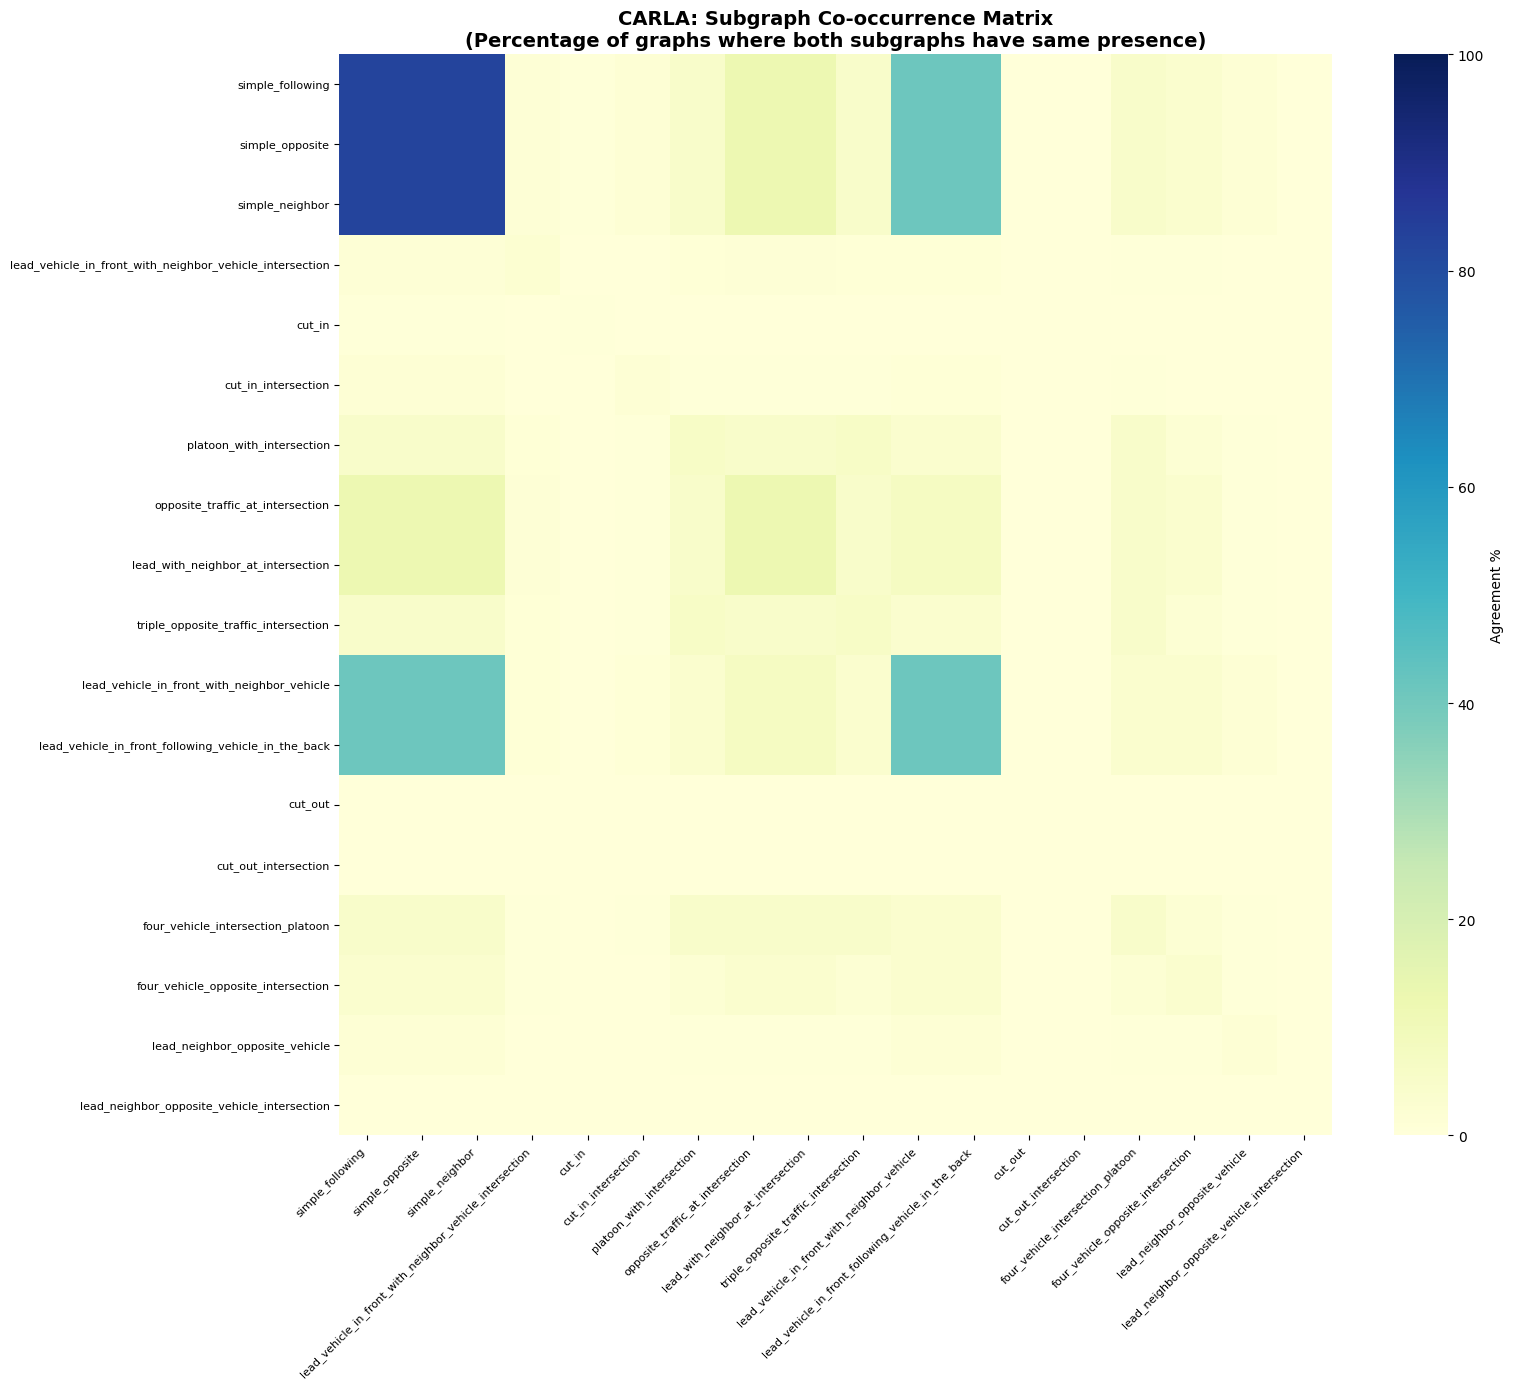

In [42]:
# Co-occurrence matrix for CARLA - showing percentage where BOTH subgraphs are present together
columns = list(coverage_graphs.keys())
n_cols = len(columns)
cooccurrence_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: percentage where this subgraph is present
            cooccurrence_matrix[i, j] = cov_data_df_carla[col1].sum() / len(cov_data_df_carla) * 100
        else:
            # Calculate percentage where BOTH subgraphs are present (co-occurrence)
            cooccurrence = (cov_data_df_carla[col1] & cov_data_df_carla[col2]).sum() / len(cov_data_df_carla) * 100
            cooccurrence_matrix[i, j] = cooccurrence

# Create DataFrame for the heatmap
cooccurrence_df_carla = pd.DataFrame(
    cooccurrence_matrix,
    index=columns,
    columns=columns
)

# Keep backward compatibility with old variable name
agreement_df_carla = cooccurrence_df_carla

# Create heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(agreement_df_carla, 
            annot=False,  # Too many cells to annotate
            cmap='YlGnBu',
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'},
            xticklabels=True,
            yticklabels=True)
plt.title('CARLA: Subgraph Co-occurrence Matrix\n(Percentage of graphs where both subgraphs have same presence)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('plots/carla_agreement_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

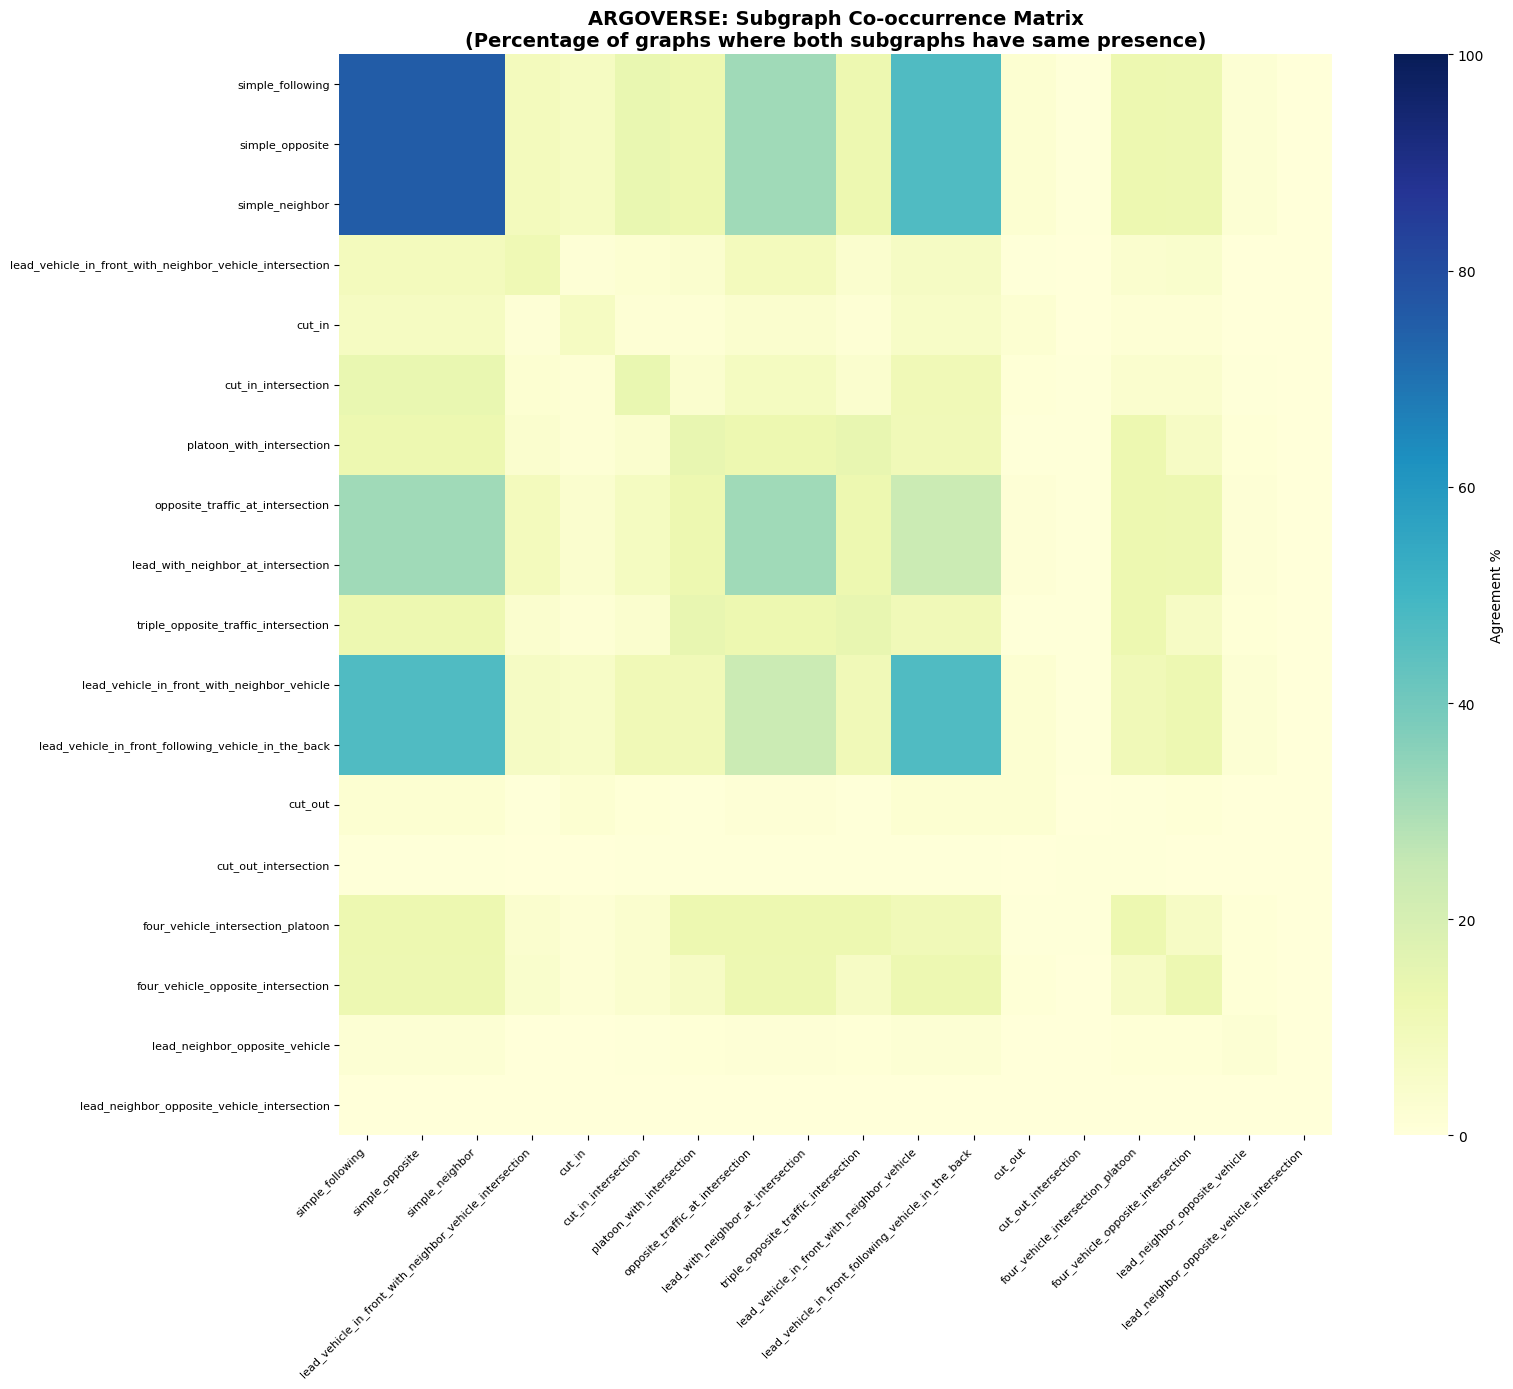

In [69]:
# Co-occurrence matrix for ARGOVERSE - showing percentage where BOTH subgraphs are present together
columns = list(coverage_graphs.keys())
n_cols = len(columns)
cooccurrence_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: percentage where this subgraph is present
            cooccurrence_matrix[i, j] = cov_data_df_argo[col1].sum() / len(cov_data_df_argo) * 100
        else:
            # Calculate percentage where BOTH subgraphs are present (co-occurrence)
            cooccurrence = (cov_data_df_argo[col1] & cov_data_df_argo[col2]).sum() / len(cov_data_df_argo) * 100
            cooccurrence_matrix[i, j] = cooccurrence

# Create DataFrame for the heatmap
cooccurrence_df_argo = pd.DataFrame(
    cooccurrence_matrix,
    index=columns,
    columns=columns
)

# Keep backward compatibility with old variable name
agreement_df_argo = cooccurrence_df_argo

# Create heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(agreement_df_argo, 
            annot=False,  # Too many cells to annotate
            cmap='YlGnBu',
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'},
            xticklabels=True,
            yticklabels=True)
plt.title('ARGOVERSE: Subgraph Co-occurrence Matrix\n(Percentage of graphs where both subgraphs have same presence)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('plots/argo_agreement_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Comparative Analysis: Co-occurrence Matrix Holes



In [ ]:
# Calculate co-occurrence holes for both datasets
# This needs to be done after the agreement matrices are created

def name_cooccurrence_hole(pattern1: str, pattern2: str) -> str:
    """
    Generate a descriptive name for a co-occurrence hole based on the two patterns involved.
    
    Args:
        pattern1: First subgraph pattern name
        pattern2: Second subgraph pattern name
    
    Returns:
        A descriptive name for the co-occurrence
    """
    # Simplified pattern names for readability
    name_map = {
        'simple_2actor_overtaking': 'Overtaking',
        'simple_2actor_following': 'Following',
        'simple_2actor_merging': 'Merging',
        'simple_2actor_crossing': 'Crossing',
        'simple_2actor_oncoming': 'Oncoming',
        'complex_3actor_chain': '3-Chain',
        'complex_3actor_merge': '3-Merge',
        'complex_3actor_split': '3-Split',
        'complex_4actor_intersection': '4-Intersection',
        'complex_multilane_weave': 'Weave'
    }
    
    short1 = name_map.get(pattern1, pattern1.replace('simple_2actor_', '').replace('complex_', '').title())
    short2 = name_map.get(pattern2, pattern2.replace('simple_2actor_', '').replace('complex_', '').title())
    
    return f"{short1} + {short2}"

# Define thresholds
argo_high_threshold = 10.0  # High co-occurrence threshold
carla_low_threshold = 2.0  # Low co-occurrence threshold

# Find co-occurrence holes in CARLA (high in Argo, low in CARLA)
carla_cooccurrence_holes = []

for i in range(len(agreement_df_carla)):
    for j in range(i+1, len(agreement_df_carla)):  # Upper triangle only
        argo_val = agreement_df_argo.iloc[i, j]
        carla_val = agreement_df_carla.iloc[i, j]
        
        if argo_val >= argo_high_threshold and carla_val < carla_low_threshold:
            pattern1 = agreement_df_carla.index[i]
            pattern2 = agreement_df_carla.columns[j]
            carla_cooccurrence_holes.append({
                'name': name_cooccurrence_hole(pattern1, pattern2),
                'pattern1': pattern1,
                'pattern2': pattern2,
                'argoverse_cooccurrence': argo_val,
                'carla_cooccurrence': carla_val,
                'difference': argo_val - carla_val
            })

# Sort by difference
carla_cooccurrence_holes_df = pd.DataFrame(carla_cooccurrence_holes).sort_values('difference', ascending=False) if len(carla_cooccurrence_holes) > 0 else pd.DataFrame(carla_cooccurrence_holes)

# Find co-occurrence holes in Argoverse (high in CARLA, low in Argo)
argo_cooccurrence_holes = []

for i in range(len(agreement_df_carla)):
    for j in range(i+1, len(agreement_df_carla)):  # Upper triangle only
        carla_val = agreement_df_carla.iloc[i, j]
        argo_val = agreement_df_argo.iloc[i, j]
        
        if carla_val >= argo_high_threshold and argo_val < carla_low_threshold:
            pattern1 = agreement_df_carla.index[i]
            pattern2 = agreement_df_carla.columns[j]
            argo_cooccurrence_holes.append({
                'name': name_cooccurrence_hole(pattern1, pattern2),
                'pattern1': pattern1,
                'pattern2': pattern2,
                'carla_cooccurrence': carla_val,
                'argoverse_cooccurrence': argo_val,
                'difference': carla_val - argo_val
            })

# Sort by difference
argo_cooccurrence_holes_df = pd.DataFrame(argo_cooccurrence_holes).sort_values('difference', ascending=False) if len(argo_cooccurrence_holes) > 0 else pd.DataFrame(argo_cooccurrence_holes)

print(f"Calculated co-occurrence holes:")
print(f"  - CARLA holes: {len(carla_cooccurrence_holes_df)}")
print(f"  - Argoverse holes: {len(argo_cooccurrence_holes_df)}")

# Display the holes with names
if len(carla_cooccurrence_holes_df) > 0:
    print(f"\n{'='*80}")
    print("CARLA Co-occurrence Holes (High in Argoverse, Low in CARLA):")
    print(f"{'='*80}")
    for idx, row in carla_cooccurrence_holes_df.iterrows():
        print(f"{idx+1}. {row['name']}")
        print(f"   Argoverse: {row['argoverse_cooccurrence']:.1f}% | CARLA: {row['carla_cooccurrence']:.1f}% | Gap: {row['difference']:.1f}%")

if len(argo_cooccurrence_holes_df) > 0:
    print(f"\n{'='*80}")
    print("Argoverse Co-occurrence Holes (High in CARLA, Low in Argoverse):")
    print(f"{'='*80}")
    for idx, row in argo_cooccurrence_holes_df.iterrows():
        print(f"{idx+1}. {row['name']}")
        print(f"   CARLA: {row['carla_cooccurrence']:.1f}% | Argoverse: {row['argoverse_cooccurrence']:.1f}% | Gap: {row['difference']:.1f}%")

# ================================================================================
# EXPORT COVERAGE HOLES TO CSV
# ================================================================================

print(f"\n{'='*80}")
print("EXPORTING COVERAGE HOLES TO CSV FILES")
print(f"{'='*80}\n")

import os
os.makedirs('coverage_holes', exist_ok=True)

# 1. SUBGRAPH HOLES: Scenarios missing in CARLA
# ------------------------------------------------
print("1. Exporting subgraph holes...")
subgraph_holes_data = []

for _, hole_row in comparison_df[comparison_df['hole_in_carla']].iterrows():
    scenario_name = hole_row['subgraph']
    # Get Argoverse graphs that contain this scenario
    argo_graphs_with_scenario = cov_data_df_argo[cov_data_df_argo[scenario_name] == True]['path'].tolist()
    
    for graph_path in argo_graphs_with_scenario:
        subgraph_holes_data.append({
            'scenario': scenario_name,
            'argoverse_graph_path': graph_path,
            'argo_absolute_count': hole_row['absolute_count_argo'],
            'argo_relative_percentage': hole_row['relative_percentage_argo'],
            'carla_absolute_count': hole_row['absolute_count_carla'],
            'carla_relative_percentage': hole_row['relative_percentage_carla'],
            'coverage_gap': hole_row['abs_diff']
        })

subgraph_holes_df = pd.DataFrame(subgraph_holes_data)
if len(subgraph_holes_df) > 0:
    subgraph_holes_df.to_csv('coverage_holes/carla_subgraph_holes.csv', index=False)
    print(f"   ✓ Saved {len(subgraph_holes_df)} Argoverse graphs with missing scenarios")
    print(f"     File: coverage_holes/carla_subgraph_holes.csv")
else:
    print("   No subgraph holes found")

# 3. CO-OCCURRENCE HOLES: Scenario combinations missing in CARLA
# ---------------------------------------------------------------
print("\n3. Exporting co-occurrence holes...")
cooccurrence_holes_data = []

for _, hole_row in carla_cooccurrence_holes_df.iterrows():
    pattern1 = hole_row['pattern1']
    pattern2 = hole_row['pattern2']
    
    # Get Argoverse graphs that contain BOTH patterns
    argo_graphs_with_both = cov_data_df_argo[
        (cov_data_df_argo[pattern1] == True) & 
        (cov_data_df_argo[pattern2] == True)
    ]['path'].tolist()
    
    for graph_path in argo_graphs_with_both:
        cooccurrence_holes_data.append({
            'combination_name': hole_row['name'],
            'pattern1': pattern1,
            'pattern2': pattern2,
            'argoverse_graph_path': graph_path,
            'argo_cooccurrence_rate': hole_row['argoverse_cooccurrence'],
            'carla_cooccurrence_rate': hole_row['carla_cooccurrence'],
            'cooccurrence_gap': hole_row['difference']
        })

cooccurrence_holes_df_export = pd.DataFrame(cooccurrence_holes_data)
if len(cooccurrence_holes_df_export) > 0:
    cooccurrence_holes_df_export.to_csv('coverage_holes/carla_cooccurrence_holes.csv', index=False)
    print(f"   ✓ Saved {len(cooccurrence_holes_df_export)} Argoverse graphs with missing combinations")
    print(f"     File: coverage_holes/carla_cooccurrence_holes.csv")
else:
    print("   No co-occurrence holes found")

print(f"\n{'='*80}")
print("CSV export complete!")
print(f"{'='*80}")


Calculated co-occurrence holes:
  - CARLA holes: 5
  - Argoverse holes: 0

CARLA Co-occurrence Holes (High in Argoverse, Low in CARLA):
1. Simple_Following + Cut_In_Intersection
   Argoverse: 13.8% | CARLA: 1.7% | Gap: 12.1%
2. Simple_Opposite + Cut_In_Intersection
   Argoverse: 13.8% | CARLA: 1.7% | Gap: 12.1%
3. Simple_Neighbor + Cut_In_Intersection
   Argoverse: 13.8% | CARLA: 1.7% | Gap: 12.1%
4. Cut_In_Intersection + Lead_Vehicle_In_Front_With_Neighbor_Vehicle
   Argoverse: 10.6% | CARLA: 1.1% | Gap: 9.4%
5. Cut_In_Intersection + Lead_Vehicle_In_Front_Following_Vehicle_In_The_Back
   Argoverse: 10.6% | CARLA: 1.1% | Gap: 9.4%


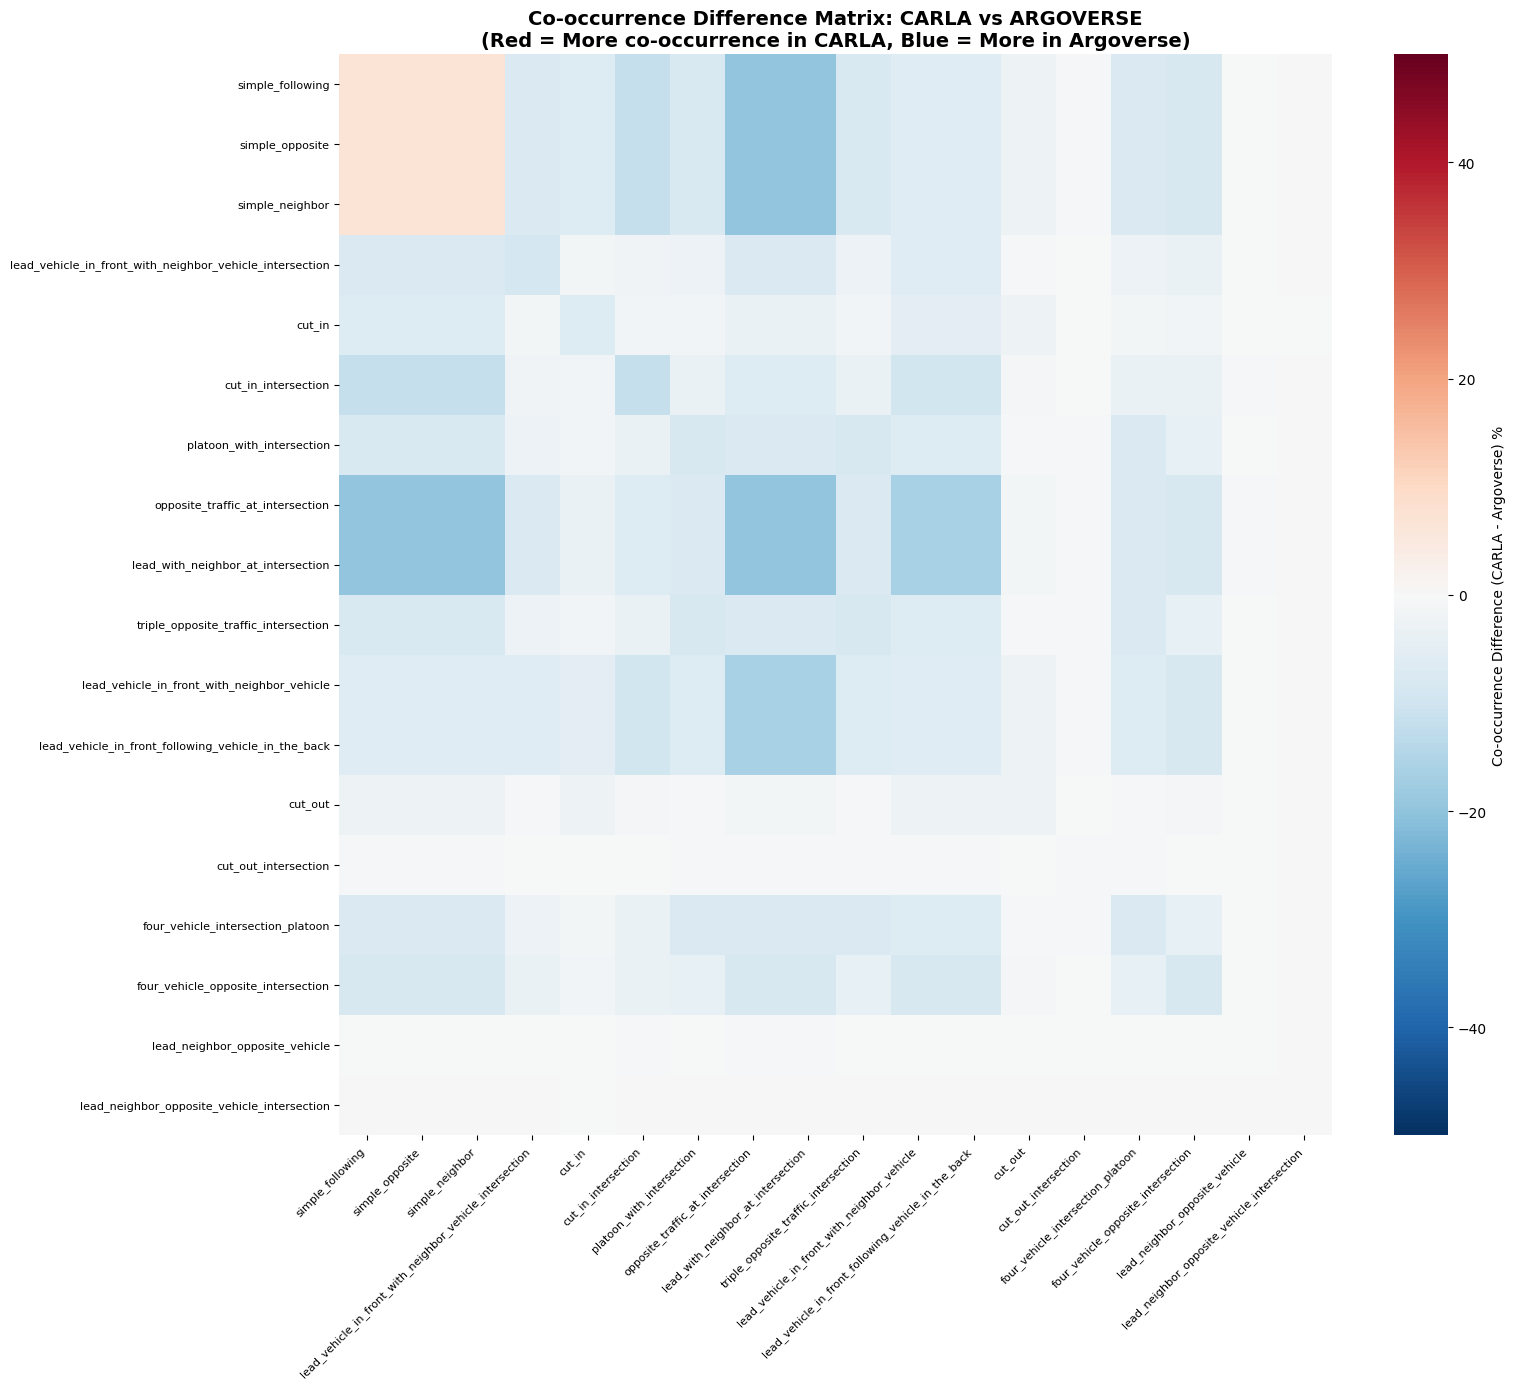


Co-occurrence Difference Summary Statistics:
  Mean absolute difference: 4.86%
  Max positive difference (more in CARLA): 6.88%
  Max negative difference (more in Argo): -19.56%
  Pairs with >10% difference: 14


In [71]:

# Visualize co-occurrence difference matrix
cooccurrence_diff = agreement_df_carla - agreement_df_argo

fig, ax = plt.subplots(figsize=(16, 14))

# Create difference heatmap
sns.heatmap(cooccurrence_diff, 
            cmap='RdBu_r', 
            center=0, 
            vmin=-50, 
            vmax=50,
            cbar_kws={'label': 'Co-occurrence Difference (CARLA - Argoverse) %'},
            xticklabels=True,
            yticklabels=True,
            ax=ax)

ax.set_title('Co-occurrence Difference Matrix: CARLA vs ARGOVERSE\n' + 
             '(Red = More co-occurrence in CARLA, Blue = More in Argoverse)', 
             fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('plots/cooccurrence_difference_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nCo-occurrence Difference Summary Statistics:")
print(f"  Mean absolute difference: {np.abs(cooccurrence_diff.values[np.triu_indices_from(cooccurrence_diff, k=1)]).mean():.2f}%")
print(f"  Max positive difference (more in CARLA): {cooccurrence_diff.values.max():.2f}%")
print(f"  Max negative difference (more in Argo): {cooccurrence_diff.values.min():.2f}%")
print(f"  Pairs with >10% difference: {(np.abs(cooccurrence_diff.values[np.triu_indices_from(cooccurrence_diff, k=1)]) > 10).sum()}")
